In [6]:
import hiplot as hip
import pandas as pd
import matplotlib.pyplot as plt
import uproot3 as uproot
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200
import random
import numpy as np
max=np.max
import seaborn as sns
from sklearn.decomposition import PCA
import os
import sys
from scipy.optimize import curve_fit
from scipy.integrate import quad

import mplhep as hep
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use([hep.styles.ATLAS])
# mpl.rcParams['mathtext.fontset'] = 'stix'
# mpl.rcParams['font.family'] = 'STIXGeneral'

from IPython.core.display import display, HTML
display(HTML(
    '<style>'
        '#notebook { padding-top:0px !important; } ' 
        '.container { width:100% !important; } '
        '.end_space { min-height:0px !important; } '
    '</style>'
))

SMALL_SIZE = 20
MEDIUM_SIZE = 22
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=17)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

%matplotlib inline

In [7]:
def getBinning(xmin,xmax,binwidth):
    nbins=int((xmax-xmin)/binwidth)
    bins=np.linspace(xmin,xmax,nbins+1)
    return bins

def makePlot(df,var,xmin,xmax,binwidth,labelx,ax,weights,scaleFactor=1.0,max_counts=0,density=False,setylim=False,**kwargs):
    if ax==None:
        fig,ax=plt.subplots(1,1)
    bins=getBinning(xmin,xmax,binwidth)
    count_edges=np.histogram(df[var],bins=bins,weights=weights)
    if scaleFactor==-1 and max_counts!=0:
        scaleFactor=max_counts/max(count_edges[0])
        count_edges=(count_edges[0]*scaleFactor,count_edges[1]) 
    else:
        count_edges=(count_edges[0]*scaleFactor,count_edges[1]) # scale the counts by some scaleFactor
    hep.histplot(count_edges,density=density,ax=ax,**kwargs)
    ax.set_xlim(xmin,xmax)
    if setylim:
        ax.set_ylim(0,max(count_edges[0])*1.15)
    ax.set_xlabel(labelx)
    return count_edges, scaleFactor

def makePlot2D(df,var1,var2,xmin,xmax,xbinwidth,ymin,ymax,ybinwidth,ax,useLog,weights,scaleFactor=1.0,max_counts=0,density=False,**kwargs):
    if ax==None:
        fig,ax=plt.subplots(1,1)
    xbins=getBinning(xmin,xmax,xbinwidth)
    ybins=getBinning(ymin,ymax,ybinwidth)
    out=np.histogram2d(df[var1],df[var2],density=density,bins=(xbins,ybins),weights=weights)
    if scaleFactor==-1 and max_counts!=0:
        out=(out[0]*max_counts/max(out[0]),out[1],out[2]) 
    else:
        out=(out[0]*scaleFactor,out[1],out[2])
    if useLog:
        hep.hist2dplot(out,ax=ax,norm=mpl.colors.LogNorm(),**kwargs)
    else:
        hep.hist2dplot(out,ax=ax,**kwargs)
    return out

def plotDiagnostic(df,weights,density=False):
    '''
    Plots 2g and 4g distributions for df and flat_df weighted by weights and f_weights
    '''
    color='black'
    fig,axes=plt.subplots(1,3,figsize=(18,5))
    
    makePlot(df,"Mpi0",0,0.4,0.002,r"$M(\gamma_1\gamma_2)$",axes[0],weights,density=density,color=color)
    #makePlot(f_df,"Mpi0",0,0.4,0.002,r"$M(\gamma_1\gamma_2)$",axes[0],f_weights,scaleFactor=scaleFactor,color=color)
    axes[0].axvline(pi0mass,c="gray",label=r"$\pi^0$ mass",linestyle='--',alpha=0.7)
    ylabel='Density' if density else 'Entries'
    axes[0].set_ylabel(f"{ylabel} / %0.3f GeV" % (0.004))
    axes[0].legend()
    
    makePlot(df,"Meta",0.3,0.9,0.004,r"$M(\gamma_3\gamma_4)$",axes[1],weights,density=density,color=color)
    #makePlot(f_df,"Meta",0.3,0.9,0.004,r"$M(\gamma_3\gamma_4)$",axes[1],f_weights,scaleFactor=scaleFactor,color=color)
    axes[1].axvline(etamass,c="gray",label=r"$\eta$ mass",linestyle='--',alpha=0.7)
    axes[1].set_ylabel(f"{ylabel} / %0.3f GeV" % (0.004))
    axes[1].legend()
    
    makePlot(df,"Mpi0eta",0,3,0.01,r"$M(4\gamma)$",axes[2],weights,density=density,color=color)
    #makePlot(f_df,"Mpi0eta",0,3,0.01,r"$M(4\gamma)$",axes[2],f_weights,scaleFactor=scaleFactor,color=color)
    axes[2].set_ylabel(f"{ylabel} / %0.2f Gev" % (0.01))
    plt.tight_layout()

In [8]:
resultsFolder="/d/grid17/ln16/dselector_v3/study_eventSelections/event_selections/"
os.system("mkdir -p "+resultsFolder+'/double_regge/')

0

In [9]:
### Physical constants
pi0mass=0.135
etamass=0.548

In [10]:
P3Cut=0.3
zMin=52
zMax=78
Rcut=2

Ecut=0.1
ueCut=0.01
mmsqCut=0.05

looseUE=0.05
looseChiSq=40

radToDeg=180/np.pi
thetaLow=2.5
thetaMed=10.3
thetaHig=11.9

In [11]:
def denoteRegion(ax,minval,maxval,withArrows,**kwargs):
    alpha=0.2
    color='magenta'
    ### SPAN
    ax.axvspan(minval,maxval,color=color,alpha=alpha,linewidth=3,**kwargs)
    ### LINES
#     ax.axvline(minval,c=color,alpha=0.3,linestyle='-')#,label=kwargs['label'])
#     ax.axvline(maxval,c=color,alpha=0.3,linestyle='-')
    ###### WITH ARROWS? 
    if withArrows:
        print("drawing arrows")
        length=(ax.get_xlim()[1]-ax.get_xlim()[0])/40#(minval-ax.get_xlim()[0])/20
        print(minval)
        ax.arrow(minval, ax.get_ylim()[1]/2, length, 0, head_width=ax.get_ylim()[1]/30, head_length=length, fc=color, ec=color, alpha=alpha+0.1)
        ax.arrow(maxval, ax.get_ylim()[1]/2, -length, 0, head_width=ax.get_ylim()[1]/30, head_length=length, fc=color, ec=color, alpha=alpha+0.1)
    ###### WITH TEXT?
#     ax.text(minval+(maxval-minval)/3,ax.get_ylim()[1]*0.5,kwargs['label'],fontsize=20,c=kwargs['color'])

In [12]:
def loadDF(fileLoc,cols):
    file=uproot.open(fileLoc)
    tree=file[b'kin']
    return tree.arrays(cols,outputtype=pd.DataFrame).reset_index(drop=True)

## Quick study to overlay two apparently ambiguous solutions

RESULT: does not appear to be a mathematical ambiguity from two interfering BW

In [8]:
# def loadMergedPols(fileName,histBaseName):
#     '''
#     We use amptools' plotter program to make histograms that were output into separate root files
#     Use this function to load the root file and grab the histogram you want ~ integrated over some set of polarizations
#     '''
#     totalValues=0
#     for pol in ['000','045','090','135']:
#         hist=uproot.open(fileName)["EtaPi0_"+pol+"_"+histBaseName]
#         edges=hist.edges
#         width=edges[1]-edges[0]
#         value=hist.values
#         totalValues+=value
#     return totalValues, edges, width

In [9]:
# file1="etapi_plot_D1--_D0+-_D1+-_D0++_D1++_D2++_pD1--_pD0+-_pD1+-_pD0++_pD1++_pD2++.root"


# fig,axes=plt.subplots(1,2,figsize=(18,6))
# for t,label,ax in zip(['010020','075100'],['0.1<t<0.2','0.75<t<1.0'],axes):
#     folder1=f"/d/grid17/ln16/dselector_v3/study_pwa/mass_dependent_fits/shared_results/systematic_nominal_v9/precision_of_NLL/v1/nominal/{t}/{t}_0/"
#     values1,edges1,width2=loadMergedPols(f'{folder1}{file1}',"Metapiacc")
#     folder1=f"/d/grid17/ln16/dselector_v3/study_pwa/mass_dependent_fits/shared_results/systematic_nominal_v9/precision_of_NLL/v1/nominal/{t}/{t}_1/"
#     values2,edges2,width2=loadMergedPols(f'{folder1}{file1}',"Metapiacc")
    
#     assert(np.prod(edges1==edges2))
#     assert(np.prod(width2==width2))
    
#     hep.histplot((values1,edges),c='black',label='Nominal',ax=ax)
#     hep.histplot((values2,edges),c='red',label='Alternative',ax=ax)
#     ax.set_ylim(0,(max(values1) if max(values1)>max(values2) else max(values2))*1.1)
#     ax.legend()
#     ax.set_xlabel(r"$M(\eta\pi)$ GeV")
#     ax.set_ylabel("Events")
#     ax.set_title(f"{label}     Coherent Sum of all $a_2+a_2\prime$")

# Cut Progression
* Proton Selections
* Final State Photon Selections
* Exclusivity
* Double Regge Region + Coherent Peak
* Accidentals

In [10]:
cols=["Mpi0eta","cosTheta_eta_gj","phi_eta_gj","cosTheta_eta_hel","phi_eta_hel","mandelstam_t","mandelstam_tp","Mpi0p","Metap","Ebeam","Meta","Mpi0","rfTime",
      "photonE1","photonE2","photonE3","photonE4",
      "photonTheta1","photonTheta2","photonTheta3","photonTheta4",
      "proton_momentum","proton_z","proton_R","proton_dEdxCDC",
      "mismatchPairMass_13","mismatchPairMass_24","mismatchPairMass_23","mismatchPairMass_14",
      "weightASBS","AccWeight","weightBS","unusedEnergy",
      "chiSq","mmsq",
      "omegaCut","pPhotonE","pPhotonTheta","pMagP3Proton","pzCutmin","pRProton","pdEdxCDCProton","pMissingMassSquared",
      "run","event",
      "pVH",#"pVH_etap","pVH_pi0p"
     ]

def loadDF_rndm(fileLoc,cols,blocksize=1e6,nblocks=1):
    file=uproot.open(fileLoc)
    tree=file[b'kin']
    entries=uproot.numentries(fileLoc,'kin')
    output_df=[]
    for iblock in range(nblocks):
        randInt=np.random.randint(entries-blocksize)
        output_df.append(tree.arrays(cols,entrystart=randInt,entrystop=randInt+blocksize,outputtype=pd.DataFrame,).reset_index(drop=True))
    return pd.concat(output_df)


fileLoc_2018_1="/d/grid17/ln16/dselector_v3/study_eventSelections/rootFiles/onlyCoherentPeak/D2018_1_selected_acc_flat.root"
fileLoc_2018_1_mc="/d/grid17/ln16/dselector_v3/study_eventSelections/rootFiles/onlyCoherentPeak/F2018_1_selected_acc_flat.root"
fileLoc_2018_8="/d/grid17/ln16/dselector_v3/study_eventSelections/rootFiles/onlyCoherentPeak/D2018_8_selected_acc_flat.root"
fileLoc_2018_8_mc="/d/grid17/ln16/dselector_v3/study_eventSelections/rootFiles/onlyCoherentPeak/F2018_8_selected_acc_flat.root"
fileLoc_2017_1="/d/grid17/ln16/dselector_v3/study_eventSelections/rootFiles/onlyCoherentPeak/D2017_1_selected_acc_flat.root"
fileLoc_2017_1_mc="/d/grid17/ln16/dselector_v3/study_eventSelections/rootFiles/onlyCoherentPeak/F2017_1_selected_acc_flat.root"

entries_2018_1=uproot.numentries(fileLoc_2018_1,'kin')
entries_2018_1_mc=uproot.numentries(fileLoc_2018_1_mc,'kin')
entries_2018_8=uproot.numentries(fileLoc_2018_8,'kin')
entries_2018_8_mc=uproot.numentries(fileLoc_2018_8_mc,'kin')
entries_2017_1=uproot.numentries(fileLoc_2017_1,'kin')
entries_2017_1_mc=uproot.numentries(fileLoc_2017_1_mc,'kin')


# df1_2018_1=loadDF_rndm(fileLoc,cols,nblocks=1)


# df1_mc_2018_1=loadDF_rndm(fileLoc,cols,nblocks=1)

### LOAD DATA
# df1_2018_8=loadDF_rndm(fileLoc,cols)

## LOAD MC
# df1_mc_2018_8=loadDF_rndm(fileLoc,cols)

# ### LOAD DATA

# df1_2018_8=loadDF_rndm(fileLoc,cols)

# ## LOAD MC
# df1_mc_2018_8=loadDF_rndm(fileLoc,cols)

In [11]:
mc_to_data_2017_1=1.*entries_2017_1_mc/entries_2017_1
mc_to_data_2018_1=1.*entries_2018_1_mc/entries_2018_1
mc_to_data_2018_8=1.*entries_2018_8_mc/entries_2018_8
print(f'MC/Data ratio 2017_1: {mc_to_data_2017_1}')
print(f'MC/Data ratio 2018_1: {mc_to_data_2018_1}')
print(f'MC/Data ratio 2018_8: {mc_to_data_2018_8}')

MC/Data ratio 2017_1: 0.35341852715599764
MC/Data ratio 2018_1: 0.2959759044185128
MC/Data ratio 2018_8: 0.3232361820835182


In [12]:
print(f'2017_1 Data:MC entries -  {entries_2017_1/1e6:0.1f}M:{entries_2017_1_mc/1e6:0.1f}M')
print(f'2018_1 Data:MC entries -  {entries_2018_1/1e6:0.1f}M:{entries_2018_1_mc/1e6:0.1f}M')
print(f'2018_8 Data:MC entries -  {entries_2018_8/1e6:0.1f}M:{entries_2018_8_mc/1e6:0.1f}M')

2017_1 Data:MC entries -  78.7M:27.8M
2018_1 Data:MC entries -  349.7M:103.5M
2018_8 Data:MC entries -  234.8M:75.9M


2017_1 data has roughly 80M entries. MC has like 30M. For the 2018 datasets we can load 80M entries for the data and 30M entries for MC by loading 80 and 30 random blocks of 1M entries. The randomization hopefully gives us some scatter of runs over the run period

In [13]:
# histogram = None

# for data in events.iterate(["E*", "p[xyz]*"], namedecode="utf-8"):
#     # operate on a batch of data in the loop
#     mass = numpy.sqrt((data["E1"] + data["E2"])**2 - (data["px1"] + data["px2"])**2 -
#                       (data["py1"] + data["py2"])**2 - (data["pz1"] + data["pz2"])**2)

#     # accumulate results
#     counts, edges = numpy.histogram(mass, bins=120, range=(0, 120))
#     if histogram is None:
#         histogram = counts, edges
#     else:
#         histogram = histogram[0] + counts, edges

# Estimate Final Yields for double regge systematics of event selections

In [14]:
def select(df,var,min1,max1,min2,max2):
    '''
    At max we will select on two different regions
    '''
    region1=(df[var]>min1)&(df[var]<max1)
    region2=(df[var]>min2)&(df[var]<max2)
    return df[region1|region2]
def listSelect(df,listOfSelections):
    tmp=df
    for selection in listOfSelections:
        tmp=select(tmp,*selection)
    return tmp

fltmax=sys.float_info.max
fltmin=-1*fltmax
def getNominalSelection():
    nominal=[
        ["unusedEnergy",fltmin,0.01,fltmin,fltmin],
        ["chiSq",fltmin,16,fltmin,fltmin],
        ["photonTheta1",2.5,10.3,11.9,fltmax],
        ["photonTheta2",2.5,10.3,11.9,fltmax],
        ["photonTheta3",2.5,10.3,11.9,fltmax],
        ["photonTheta4",2.5,10.3,11.9,fltmax],
        ["photonE1",0.1,fltmax,fltmin,fltmin],
        ["photonE2",0.1,fltmax,fltmin,fltmin],
        ["photonE3",0.1,fltmax,fltmin,fltmin],
        ["photonE4",0.1,fltmax,fltmin,fltmin],
        ["proton_momentum",0.3,fltmax,fltmin,fltmin],
        ["proton_z",52,78,fltmin,fltmin],
        ["mmsq",-0.05,0.05,fltmin,fltmin]
    ]
    return nominal



selectionMap={"ueL1": [[0,["unusedEnergy",fltmin,0.25,fltmin,fltmin]]],
    "ueL2": [[0,["unusedEnergy",fltmin,fltmax,fltmin,fltmin]]],
    "chiT": [[1,["chiSq",fltmin,11,fltmin,fltmin]]],
    "chiL": [[1,["chiSq",fltmin,40,fltmin,fltmin]]],
    "gThetaBeamL": [[2,["photonTheta1",2.0,10.3,11.9,fltmax]],  ### C 
        [3,["photonTheta2",2.0,10.3,11.9,fltmax]], 
        [4,["photonTheta3",2.0,10.3,11.9,fltmax]],
        [5,["photonTheta4",2.0,10.3,11.9,fltmax]]],
    "gThetaBeamT": [[2,["photonTheta1",3.0,10.3,11.9,fltmax]], ### C 
        [3,["photonTheta2",3.0,10.3,11.9,fltmax]],
        [4,["photonTheta3",3.0,10.3,11.9,fltmax]],
        [5,["photonTheta4",3.0,10.3,11.9,fltmax]]],
    "gThetaTransL": [[2,["photonTheta1",2.5,11.4,11.4,fltmax]], 
        [3,["photonTheta2",2.5,11.4,11.4,fltmax]],
        [4,["photonTheta3",2.5,11.4,11.4,fltmax]],
        [5,["photonTheta4",2.5,11.4,11.4,fltmax]]],
    "gThetaTransT": [[2,["photonTheta1",2.5,10.0,12.5,fltmax]], 
        [3,["photonTheta2",2.5,10.0,12.5,fltmax]],
        [4,["photonTheta3",2.5,10.0,12.5,fltmax]],
        [5,["photonTheta4",2.5,10.0,12.5,fltmax]]],
    "gET1":[[6,["photonE1",0.12,fltmax,fltmin,fltmin]], 
        [7,["photonE2",0.12,fltmax,fltmin,fltmin]],
        [8,["photonE3",0.12,fltmax,fltmin,fltmin]],
        [9,["photonE4",0.12,fltmax,fltmin,fltmin]]],
    "gET2": [[6,["photonE1",0.13,fltmax,fltmin,fltmin]],
        [7,["photonE2",0.13,fltmax,fltmin,fltmin]],
        [8,["photonE3",0.13,fltmax,fltmin,fltmin]],
        [9,["photonE4",0.13,fltmax,fltmin,fltmin]]],
    "pMomT1": [[10,["proton_momentum",0.5,fltmax,fltmin,fltmin]]],
    "pMomT2": [[10,["proton_momentum",0.6,fltmax,fltmin,fltmin]]],
    "pZL": [[11,["proton_z",50,80,fltmin,fltmin]]],
    "pZT": [[11,["proton_z",54,76,fltmin,fltmin]]],
    "mmsqT1": [[12,["mmsq",-0.025,0.025,fltmin,fltmin]]],
    "mmsqT2": [[12,["mmsq",-0.020,0.020,fltmin,fltmin]]]
}
variations=list(selectionMap.keys())

def getModifiedSelection(variation,selectionMap):
    nominal=getNominalSelection()
    selections=selectionMap[variation]
    for selection in selections:
        i,selectionSet = selection
        nominal[i]=selectionSet
    return nominal

# Argue basic cuts with small subset of data

In [15]:
cols=["Mpi0eta","cosTheta_eta_gj","phi_eta_gj","cosTheta_eta_hel","phi_eta_hel","mandelstam_t","mandelstam_tp","Mpi0p","Metap","Ebeam","Meta","Mpi0","rfTime",
      "photonE1","photonE2","photonE3","photonE4",
      "photonTheta1","photonTheta2","photonTheta3","photonTheta4",
      "proton_momentum","proton_z","proton_R","proton_dEdxCDC",
      "mismatchPairMass_13","mismatchPairMass_24","mismatchPairMass_23","mismatchPairMass_14",
      "weightASBS","AccWeight","weightBS","unusedEnergy",
      "chiSq","mmsq",
      "omegaCut","pPhotonE","pPhotonTheta","pMagP3Proton","pzCutmin","pRProton","pdEdxCDCProton","pMissingMassSquared",
      "run","event",
      "pVH","pVH_etap","pVH_pi0p"
     ]

fileLoc="/d/grid17/ln16/dselector_v3/study_eventSelections/rootFiles/onlyCoherentPeak/D2017_1_selected_acc_flat.root"
df1=loadDF(fileLoc,cols)
fileLoc="/d/grid17/ln16/dselector_v3/study_eventSelections/rootFiles/onlyCoherentPeak/F2017_1_selected_acc_flat.root"
df1_mc=loadDF(fileLoc,cols)
run_period="2017_1"

In [15]:
### Apparently the "newer" selected 2018 datasets did not include pVH_etap and pVH_pi0p. Have to modify DSelector 
cols=["Mpi0eta","cosTheta_eta_gj","phi_eta_gj","cosTheta_eta_hel","phi_eta_hel","mandelstam_t","mandelstam_tp","Mpi0p","Metap","Ebeam","Meta","Mpi0","rfTime",
      "photonE1","photonE2","photonE3","photonE4",
      "photonTheta1","photonTheta2","photonTheta3","photonTheta4",
      "proton_momentum","proton_z","proton_R","proton_dEdxCDC",
      "mismatchPairMass_13","mismatchPairMass_24","mismatchPairMass_23","mismatchPairMass_14",
      "weightASBS","AccWeight","weightBS","unusedEnergy",
      "chiSq","mmsq",
      "omegaCut","pPhotonE","pPhotonTheta","pMagP3Proton","pzCutmin","pRProton","pdEdxCDCProton","pMissingMassSquared",
      "run","event",
      "pVH"
     ]

df1=loadDF_rndm(fileLoc_2018_1,cols,nblocks=80) # Load 8M entries to match the size of the spring 2017 dataset
df1_mc=loadDF_rndm(fileLoc_2018_1_mc,cols,nblocks=30) # Load 3M entries to match the size of the spring 2017 MC
run_period="2018_1"

# df1=loadDF_rndm(fileLoc_2018_8,cols,nblocks=80) # Load 8M entries to match the size of the spring 2017 dataset
# df1_mc=loadDF_rndm(fileLoc_2018_8_mc,cols,nblocks=30) # Load 3M entries to match the size of the spring 2017 MC
# run_period="2018_8"

## First selection is the beam energy

In [16]:
df1=df1[(df1.Ebeam>8.2)&(df1.Ebeam<8.8)]
df1_mc=df1_mc[(df1_mc.Ebeam>8.2)&(df1_mc.Ebeam<8.8)]

'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


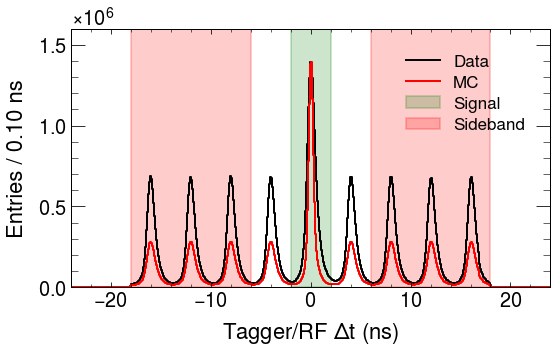

In [17]:
fig,axes=plt.subplots(1,1,figsize=(8,5))
axes=[axes]

# #scale the MC by this factor to try and match the yields
# scaleFactor=-1
# if run_period=='2017_1':
#     scaleFactor=2
# elif run_period=='2018_1':
#     scaleFactor=1.3
# elif run_period=='2018_8':
#     scaleFactor=1.3

counts=makePlot(df1,"rfTime",-24,24,0.1,"RF Time (ns)",axes[0],[1]*len(df1),c='black',alpha=1,label="Data",setylim=True)[0][0]
makePlot(df1_mc,"rfTime",-24,24,0.1,r"Tagger/RF $\Delta t$ (ns)",axes[0],[1]*len(df1_mc),scaleFactor=-1,max_counts=max(counts),c='red',alpha=1,label="MC")
axes[0].axvspan(-2,2,label="Signal",linewidth=2,color='green',alpha=0.2)
axes[0].axvspan(6,18,label="Sideband",linewidth=2,color='red',alpha=0.2)
axes[0].axvspan(-18,-6,color='red',linewidth=2,alpha=0.2)
axes[0].set_ylabel("Entries / %0.2f ns" % (0.1))
axes[0].set_ylim(0,axes[0].get_ylim()[1])
axes[0].legend()#bbox_to_anchor=(0.45,0.9))#prop={"size":24})

plt.tight_layout()
plt.savefig(resultsFolder+f"/rf_time_subtraction_coherentPeakSelectOnly_{run_period}.pdf")

'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


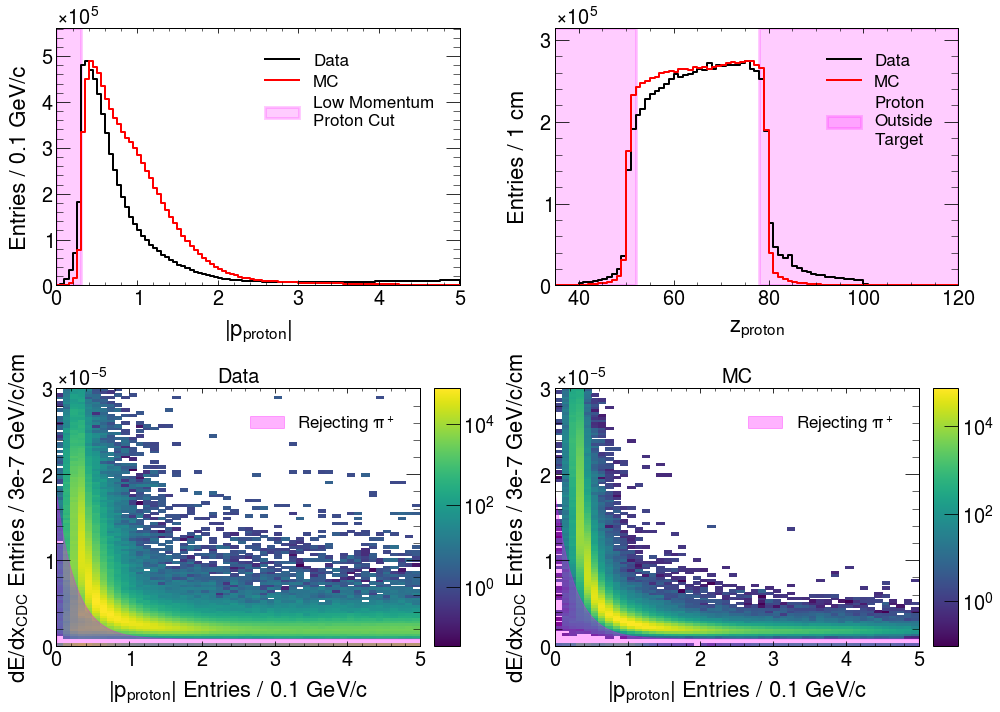

In [18]:
fig,axes=plt.subplots(2,2,figsize=(14,10))
axes=axes.flatten()

# weights=[1]*len(df1)
# weights_mc=[1]*len(df1_mc)
weights=df1.AccWeight
weights_mc=df1_mc.AccWeight

# #scale the MC by this factor to try and match the yields
# scaleFactor=-1
# if run_period=='2017_1':
#     scaleFactor=2
# elif run_period=='2018_1':
#     scaleFactor=1.6
# elif run_period=='2018_8':
#     scaleFactor=1.6

counts=makePlot(df1,"proton_momentum",0,5,0.05,r"$|p_{proton}|$",axes[0],weights,color='black',label="Data",setylim=True)[0][0]
makePlot(df1_mc,"proton_momentum",0,5,0.05,r"$|p_{proton}|$",axes[0],weights_mc,scaleFactor=-1,max_counts=max(counts),color='red',label="MC")
# axes[0].axvspan(0,0.3,label="Low Momentum\nProton Cut",color='red')
denoteRegion(axes[0],0,0.3,False,label="Low Momentum\nProton Cut")
# denoteRegion(axes[0],0.3,axes[0].get_xlim()[1],True,label="Select Protons")
axes[0].set_ylabel("Entries / %0.1f GeV/c" % (0.1))
axes[0].legend()

counts=makePlot(df1,"proton_z",35,120,1,r"$z_{proton}$",axes[1],weights,color='black',label="Data",setylim=True)[0][0]
makePlot(df1_mc,"proton_z",35,120,1,r"$z_{proton}$",axes[1],weights_mc,scaleFactor=-1,max_counts=max(counts),color='red',label="MC")
# axes[1].axvspan(0,42,label="Proton In\nTarget",color='red')
# axes[1].axvspan(82,axes[1].get_xlim()[1],color='red')
denoteRegion(axes[1],0,zMin,False,label="Proton\nOutside\nTarget")
denoteRegion(axes[1],zMax,axes[1].get_xlim()[1],False,label="")
# denoteRegion(axes[1],42,82,True,label="Select Protons\nFrom Target")
axes[1].set_ylabel("Entries / %0.0f cm" % (1))
axes[1].legend()

# makePlot(df1,"proton_R",0,5,0.1,r"$R_{proton}$",axes[2],weights,color='black',label="Data")
# #axes[2].axvspan(2,axes[2].get_xlim()[1],label="Proton In Target",color='red')
# denoteRegion(axes[2],2,axes[2].get_xlim()[1],False,label="Proton\nOutside\nTarget")
# # denoteRegion(axes[2],0,2,True,label="Select Protons\nFrom Target")
# axes[2].set_ylabel("Entries / %0.1f cm" % (0.1))
# axes[2].legend()

max_counts=0
for i,df,weight,label,iax in zip(range(2),[df1,df1_mc],[weights,weights_mc],["Data","MC"],range(2,4)):
    if i==0:
        counts=makePlot2D(df,"proton_momentum","proton_dEdxCDC",0,5,0.1,0,30e-6,3e-7,axes[iax],True,weight,linewidth=0,rasterized=True,label=label)[0]
    else:
        makePlot2D(df,"proton_momentum","proton_dEdxCDC",0,5,0.1,0,30e-6,3e-7,axes[iax],True,weight,scaleFactor=-1,max_counts=max(counts),linewidth=0,rasterized=True,label=label)
    axes[iax].set_xlabel(r"$|p_{proton}|$ Entries / 0.1 GeV/c")
    axes[iax].set_ylabel(r"$dE/dx_{CDC}$ Entries / 3e-7 GeV/c/cm")
    def dEdxCurve(pmag):
        return 1e-6*(0.9+np.exp(3.0-3.5*(pmag+0.05)/.93827))
    pmags=np.linspace(*axes[iax].get_xlim(),100)
    axes[iax].fill_between(pmags,dEdxCurve(pmags),label="Rejecting $\pi^+$",color='magenta',alpha=0.3)
    axes[iax].set_title(label)
    axes[iax].legend()

plt.tight_layout()
plt.savefig(resultsFolder+f"/proton_cuts_{run_period}.pdf")

## Compare dedx selection (rho analysis, current etapi nominal, 2017 analysis launch)

In [19]:
# https://halldweb.jlab.org/DocDB/0055/005576/009/Analysis_Note__rho_SDMEs_20221123.pdf
# https://halldweb.jlab.org/wiki/index.php/Spring_2017_Analysis_Launch_Cuts

In [20]:
xbins=getBinning(0,5,0.1)
ybins=getBinning(0,30e-6,3e-7)
mom_vs_dedx=np.histogram2d(df1.proton_momentum,df1.proton_dEdxCDC,weights=df1.AccWeight,bins=(xbins,ybins))

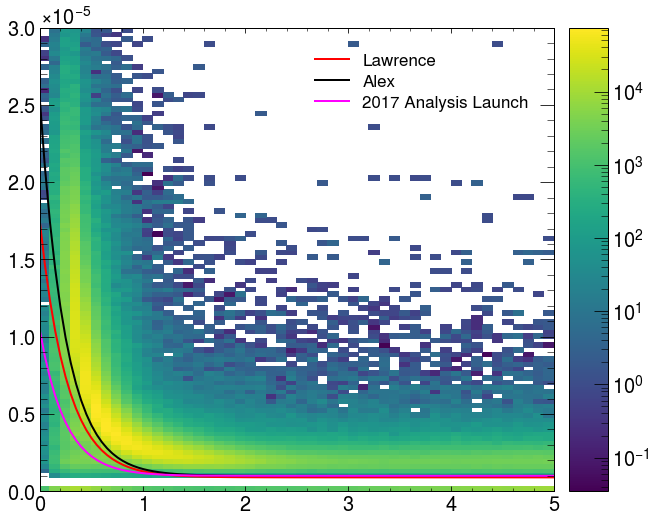

In [21]:
def dEdxCurve_lawrence(pmag):
    return 1e-6*(0.9+np.exp(3.0-3.5*(pmag+0.05)/.93827))
def dEdxCurve_alex(pmag):
    # exp(4p+3.2) +1
    return 1e-6*(np.exp(-4*pmag+3.2)+1.0)
def dEdxCurve_2017Launch(pmag):
    #dE/dx > e^(-4.0*p + 2.25) + 1.0
    return 1e-6*(np.exp(-4.0*pmag+2.25)+1.0)

plt.figure(figsize=(10,8))
hep.hist2dplot(mom_vs_dedx,norm=mpl.colors.LogNorm())
plt.plot(pmags,dEdxCurve_lawrence(pmags),c='red',label='Lawrence')
plt.plot(pmags,dEdxCurve_alex(pmags),c='black',label='Alex')
plt.plot(pmags,dEdxCurve_2017Launch(pmags),c='magenta',label='2017 Analysis Launch')
plt.legend()

'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


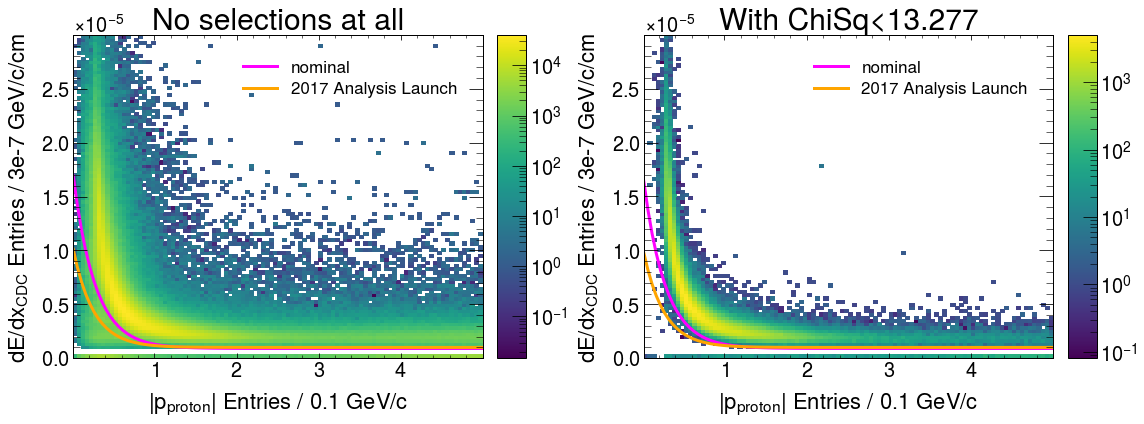

In [22]:
def dEdxCurve(pmag):
    return 1e-6*(0.9+np.exp(3.0-3.5*(pmag+0.05)/.93827))
def dEdxCurve_nom(pmag):
    return 1e-6*(np.exp(-4*pmag+2.25)+1.0)

fig,axes=plt.subplots(1,2,figsize=(16,6))
axes=axes.flatten()

tmp=df1
tmp=tmp[(tmp["proton_momentum"]<5)&(tmp["proton_dEdxCDC"]<3e-5)]
hep.hist2dplot(np.histogram2d(tmp["proton_momentum"],tmp["proton_dEdxCDC"],weights=tmp.AccWeight,bins=(100,100)),ax=axes[0],norm=mpl.colors.LogNorm())
axes[0].set_xlabel(r"$|p_{proton}|$ Entries / 0.1 GeV/c")
axes[0].set_ylabel(r"$dE/dx_{CDC}$ Entries / 3e-7 GeV/c/cm")
pmags=np.linspace(*axes[0].get_xlim(),100)
axes[0].plot(pmags,dEdxCurve(pmags),label='nominal',color='magenta',alpha=1,linewidth=3)
axes[0].plot(pmags,dEdxCurve_nom(pmags),label="2017 Analysis Launch",color='orange',alpha=1,linewidth=3)
axes[0].set_title("No selections at all",size=30)
axes[0].legend()

tmp=tmp[tmp["chiSq"]<13.277]
hep.hist2dplot(np.histogram2d(tmp["proton_momentum"],tmp["proton_dEdxCDC"],weights=tmp.AccWeight,bins=(100,100)),ax=axes[1],norm=mpl.colors.LogNorm())
axes[1].set_xlabel(r"$|p_{proton}|$ Entries / 0.1 GeV/c")
axes[1].set_ylabel(r"$dE/dx_{CDC}$ Entries / 3e-7 GeV/c/cm")
pmags=np.linspace(*axes[1].get_xlim(),100)
axes[1].plot(pmags,dEdxCurve(pmags),label='nominal',color='magenta',alpha=1,linewidth=3)
axes[1].plot(pmags,dEdxCurve_nom(pmags),label="2017 Analysis Launch",color='orange',alpha=1,linewidth=3)
axes[1].set_title("With ChiSq<13.277",size=30)
axes[1].legend()

plt.tight_layout()
plt.savefig(resultsFolder+f"/dedx_nomVsAnaLaunch_cuts_{run_period}.pdf")

## Apply proton selections

In [23]:
df2=df1[(df1.pMagP3Proton)&(df1.pzCutmin)&(df1.pdEdxCDCProton)&(df1.pPhotonTheta)]
df2_mc=df1_mc[(df1_mc.pMagP3Proton)&(df1_mc.pzCutmin)&(df1_mc.pdEdxCDCProton)&(df1_mc.pPhotonTheta)]
# plotDiagnostic(df2,[1]*len(df2))
# plotDiagnostic(df2,df2.AccWeight)

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


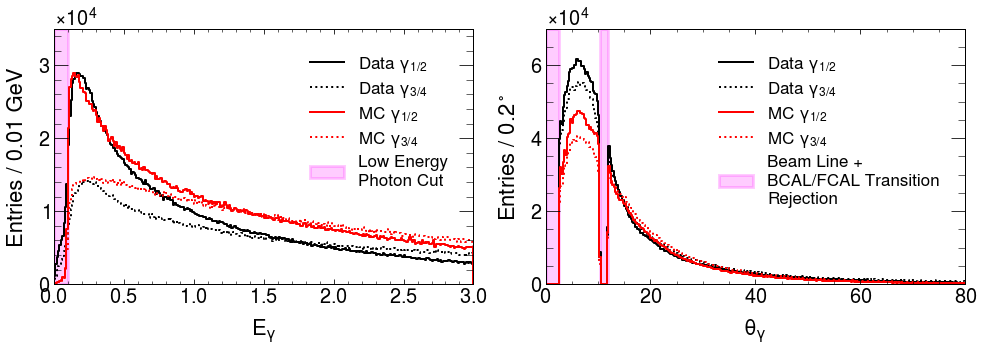

In [24]:
fig,axes=plt.subplots(1,2,figsize=(14,5))
axes=axes.flatten()

#weights=[1]*len(df2)
weights=df2.AccWeight
weights_mc=df2_mc.AccWeight

# scaleFactor=-1
# if run_period=='2017_1':
#     scaleFactor=2
# elif run_period=='2018_1':
#     scaleFactor=1.6
# elif run_period=='2018_8':
#     scaleFactor=1.6


counts=makePlot(df2,"photonE1",0,3,0.01,r"$E_{\gamma}$",axes[0],weights,color='black',alpha=1,label="Data $\gamma_{1/2}$")[0][0]
makePlot(df2,"photonE3",0,3,0.01,r"$E_{\gamma}$",axes[0],weights,color='black',linestyle='dotted',alpha=1,label="Data $\gamma_{3/4}$")
scaleFactor=makePlot(df2_mc,"photonE1",0,3,0.01,r"$E_{\gamma}$",axes[0],weights_mc,scaleFactor=-1,max_counts=max(counts),color='red',alpha=1,label="MC $\gamma_{1/2}$")[1]
makePlot(df2_mc,"photonE3",0,3,0.01,r"$E_{\gamma}$",axes[0],weights_mc,scaleFactor=scaleFactor,color='red',linestyle='dotted',alpha=1,label="MC $\gamma_{3/4}$")
#axes[0].axvspan(0,Ecut,label="Low Energy\nPhoton Cut",color='red',alpha=0.4)
denoteRegion(axes[0],0,Ecut,False,label="Low Energy\nPhoton Cut")
axes[0].set_ylabel("Entries / %0.2f GeV" % (0.01))
axes[0].legend()#prop={"size":24})

counts=makePlot(df2,"photonTheta1",0,80,0.25,r"$\theta_{\gamma}$",axes[1],weights,color='black',alpha=1,label="Data $\gamma_{1/2}$")[0][0]
makePlot(df2,"photonTheta3",0,80,0.25,r"$\theta_{\gamma}$",axes[1],weights,color='black',linestyle='dotted',alpha=1,label="Data $\gamma_{3/4}$")
makePlot(df2_mc,"photonTheta1",0,80,0.25,r"$\theta_{\gamma}$",axes[1],weights_mc,color='red',alpha=1,label="MC $\gamma_{1/2}$")
makePlot(df2_mc,"photonTheta3",0,80,0.25,r"$\theta_{\gamma}$",axes[1],weights_mc,color='red',linestyle='dotted',alpha=1,label="MC $\gamma_{3/4}$")
# axes[1].axvspan(0,thetaLow,color='red',alpha=0.4,label="Beam Line +\nBCAL/FCAL Transition\nRejection")
# axes[1].axvspan(thetaMed,thetaHig,label="",color='red',alpha=0.4)
denoteRegion(axes[1],0,thetaLow,False,label="Beam Line +\nBCAL/FCAL Transition\nRejection")
denoteRegion(axes[1],thetaMed,thetaHig,False,label="")
axes[1].set_ylabel("Entries / %0.1f$^\circ$" % (0.25))
axes[1].legend()

plt.tight_layout()
plt.savefig(resultsFolder+f"/photon_cuts_{run_period}.pdf")

## Apply photon selections

In [25]:
df3=df2[(df2.pPhotonE)&(df2.pPhotonTheta)]
df3_mc=df2_mc[(df2_mc.pPhotonE)&(df2_mc.pPhotonTheta)]

# plotDiagnostic(df3,[1]*len(df3))
# plotDiagnostic(df3,df3.AccWeight)

'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


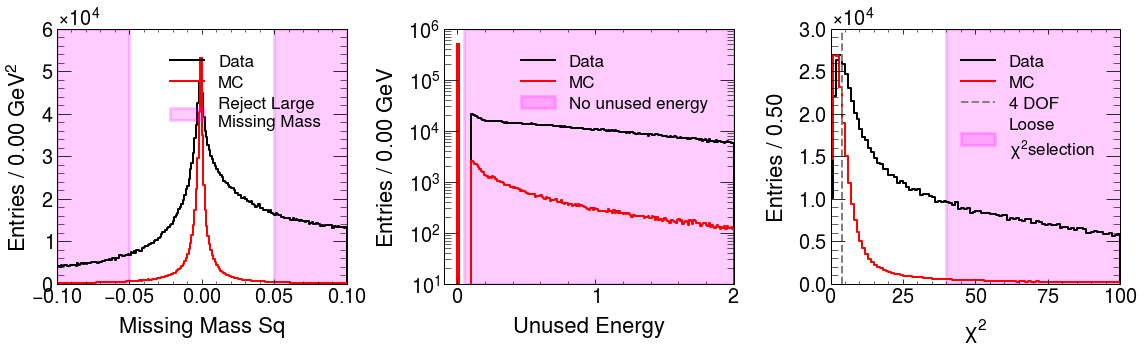

In [26]:
fig,axes=plt.subplots(1,3,figsize=(16,5))

# weights=[1]*len(df3)
weights=df3.AccWeight
weights_mc=df3_mc.AccWeight

# scaleFactor=-1
# if run_period=='2017_1':
#     scaleFactor=0.3
# elif run_period=='2018_1':
#     scaleFactor=0.3
# elif run_period=='2018_8':
#     scaleFactor=0.3

counts=makePlot(df3,"mmsq",-0.1,0.1,0.001,"Missing Mass Sq",axes[0],weights,color='black',alpha=1,label="Data")[0][0]
makePlot(df3_mc,"mmsq",-0.1,0.1,0.001,"Missing Mass Sq",axes[0],weights_mc,scaleFactor=-1,max_counts=max(counts),color='red',alpha=1,label="MC")
# axes[0].axvspan(-0.1,-0.05,label="Reject Large\nMissing Mass",color='red',alpha=0.4)
# axes[0].axvspan(0.05,0.1,color='red',alpha=0.4)
denoteRegion(axes[0],-0.1,-0.05,False,label="Reject Large\nMissing Mass")
denoteRegion(axes[0],0.05,0.1,False)
axes[0].set_ylabel("Entries / %0.2f $GeV^2$" % (0.001))
axes[0].legend()#prop={"size":24})

counts=makePlot(df3,"unusedEnergy",-0.1,2,0.01,"Unused Energy",axes[1],weights,color='black',alpha=1,label="Data")[0][0]
makePlot(df3_mc,"unusedEnergy",-0.1,2,0.01,"Unused Energy",axes[1],weights_mc,scaleFactor=-1,max_counts=max(counts),color='red',alpha=1,label="MC")
#axes[1].axvspan(looseUE,2,color='red',alpha=0.4,label="Loosely\nenforce\nshower\nquantity")
denoteRegion(axes[1],looseUE,2,False,label="No unused energy")
axes[1].set_ylabel("Entries / %0.2f $GeV$" % (0.001))
axes[1].set_yscale('log')
axes[1].legend()#prop={"size":24})

counts=makePlot(df3,"chiSq",0,100,1,"$\chi^2$",axes[2],weights,color='black',alpha=1,label="Data")[0][0]
makePlot(df3_mc,"chiSq",0,100,1,"$\chi^2$",axes[2],weights_mc,scaleFactor=-1,max_counts=max(counts),color='red',alpha=1,label="MC")
#axes[2].axvspan(looseChiSq,300,color='red',alpha=0.4,label="Loose\n$\chi^2 selection$")
denoteRegion(axes[2],looseChiSq,300,False,label="Loose\n$\chi^2 selection$")
axes[2].set_ylabel("Entries / %0.2f" % (0.5))
axes[2].axvline(4,c='gray',linestyle='--',label="4 DOF")
axes[2].legend()#prop={"size":24})

plt.tight_layout()
plt.savefig(resultsFolder+f"/exclusivity_cuts_{run_period}.pdf")

'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


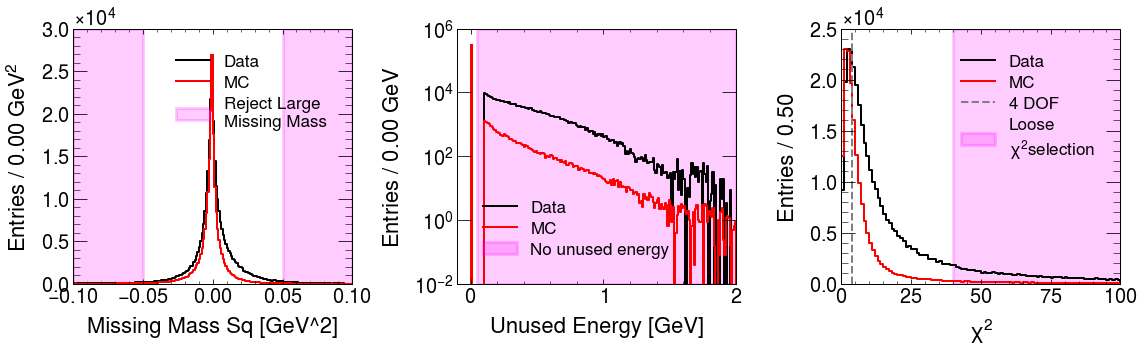

In [27]:
df3_mmsq=df3[(df3.unusedEnergy==0)&(df3.chiSq<40)]
df3_ue=df3[(df3.mmsq<0.05)&(df3.chiSq<40)]
df3_chiSq=df3[(df3.mmsq<0.05)&(df3.unusedEnergy==0)]

df3_mc_mmsq=df3_mc[(df3_mc.unusedEnergy==0)&(df3_mc.chiSq<40)]
df3_mc_ue=df3_mc[(df3_mc.mmsq<0.05)&(df3_mc.chiSq<40)]
df3_mc_chiSq=df3_mc[(df3_mc.mmsq<0.05)&(df3_mc.unusedEnergy==0)]

# scaleFactors=[-1,-1,-1]
# if run_period=='2017_1':
#     scaleFactors=[0.2,5,0.15]
# elif run_period=='2018_1':
#     scaleFactor=[0.2,5,0.15]
# elif run_period=='2018_8':
#     scaleFactor=[0.2,5,0.15]

fig,axes=plt.subplots(1,3,figsize=(16,5))

counts=makePlot(df3_mmsq,"mmsq",-0.1,0.1,0.001,r"Missing Mass Sq [GeV^2]",axes[0],df3_mmsq.AccWeight,color='black',alpha=1,label="Data")[0][0]
makePlot(df3_mc_mmsq,"mmsq",-0.1,0.1,0.001,r"Missing Mass Sq [GeV^2]",axes[0],df3_mc_mmsq.AccWeight,scaleFactor=-1,max_counts=max(counts),color='red',alpha=1,label="MC")
# axes[0].axvspan(-0.1,-0.05,label="Reject Large\nMissing Mass",color='red',alpha=0.4)
# axes[0].axvspan(0.05,0.1,color='red',alpha=0.4)
denoteRegion(axes[0],-0.1,-0.05,False,label="Reject Large\nMissing Mass")
denoteRegion(axes[0],0.05,0.1,False)
axes[0].set_ylim(0)
axes[0].set_ylabel("Entries / %0.2f $GeV^2$" % (0.001))
axes[0].legend()#prop={"size":24})

counts=makePlot(df3_ue,"unusedEnergy",-0.1,2,0.01,"Unused Energy [GeV]",axes[1],df3_ue.AccWeight,color='black',alpha=1,label="Data")[0][0]
makePlot(df3_mc_ue,"unusedEnergy",-0.1,2,0.01,"Unused Energy [GeV]",axes[1],df3_mc_ue.AccWeight,scaleFactor=-1,max_counts=max(counts),color='red',alpha=1,label="MC")
#axes[1].axvspan(looseUE,2,color='red',alpha=0.4,label="Loosely\nenforce\nshower\nquantity")
denoteRegion(axes[1],looseUE,2,False,label="No unused energy")
axes[1].set_ylabel("Entries / %0.2f $GeV$" % (0.001))
axes[1].set_yscale('log')
axes[1].legend()#prop={"size":24})

counts=makePlot(df3_chiSq,"chiSq",0,100,1,"$\chi^2$",axes[2],df3_chiSq.AccWeight,color='black',alpha=1,label="Data")[0][0]
makePlot(df3_mc_chiSq,"chiSq",0,100,1,"$\chi^2$",axes[2],df3_mc_chiSq.AccWeight,scaleFactor=-1,max_counts=max(counts),color='red',alpha=1,label="MC")
#axes[2].axvspan(looseChiSq,300,color='red',alpha=0.4,label="Loose\n$\chi^2 selection$")
denoteRegion(axes[2],looseChiSq,300,False,label="Loose\n$\chi^2 selection$")
axes[2].set_ylabel("Entries / %0.2f" % (0.5))
axes[2].axvline(4,c='gray',linestyle='--',label="4 DOF")
axes[2].legend()#prop={"size":24})

plt.tight_layout()
plt.savefig(resultsFolder+f"/exclusivity_cuts_othersApplied_{run_period}.pdf")

In [32]:
eta_sig=3.0
eta_skip=2.0
eta_sb=6.0
eta_peak=0.548;
eta_std=0.0123;
etasigL=eta_peak-eta_sig*eta_std;
etasigR=eta_peak+eta_sig*eta_std;
etasbRL=eta_peak+(eta_sig+eta_skip)*eta_std;
etasbLR=eta_peak-(eta_sig+eta_skip)*eta_std;
etasbRR=eta_peak+(eta_sig+eta_skip+eta_sb)*eta_std;
etasbLL=eta_peak-(eta_sig+eta_skip+eta_sb)*eta_std;
print(f'{etasigL:0.4f},{etasigR:0.4f}')
print(f'{etasbRL:0.4f},{etasbRR:0.4f}')
print(f'{etasbLL:0.4f},{etasbLR:0.4f}')

0.5111,0.5849
0.6095,0.6833
0.4127,0.4865


In [28]:
# plt.title("Minimal events large MMSq")
# tmp_df=df3[(df3.chiSq<looseChiSq)&(df3.unusedEnergy<0.05)]
# hep.histplot(np.histogram(tmp_df.mmsq, bins=75))
# plt.tight_layout()
# plt.axvline(0.05,c='red',linestyle='--')
# plt.axvline(-0.05,c='red',linestyle='--')
# plt.xlabel("MMSq")

## Apply exclusivity selections - loose

In [29]:
df4=df3[(df3.pMissingMassSquared)&(df3.unusedEnergy<0.05)&(df3.chiSq<looseChiSq)]
df4_mc=df3_mc[(df3_mc.pMissingMassSquared)&(df3_mc.unusedEnergy<0.05)&(df3_mc.chiSq<looseChiSq)]

'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
/d/home/ln16/.local/lib/python3.6/site-packages/mplhep/plot.py:316: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  _bins, _h, where="post", label=_step_label, marker="", **_kwargs
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


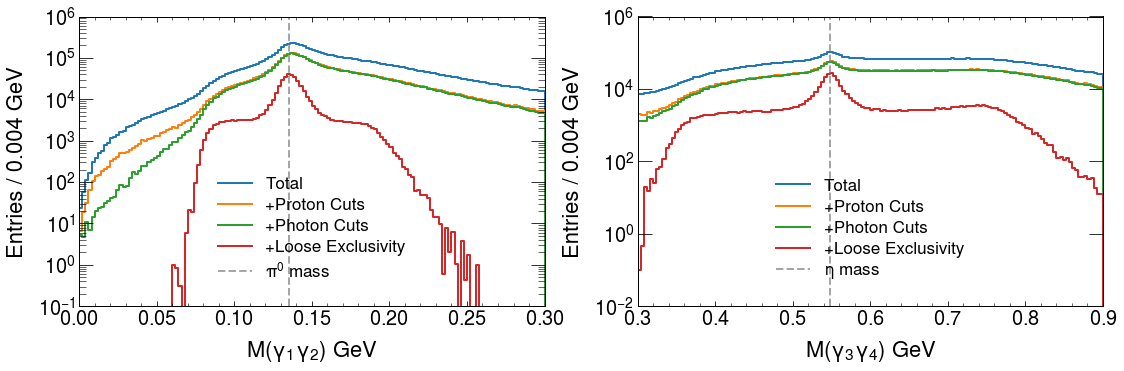

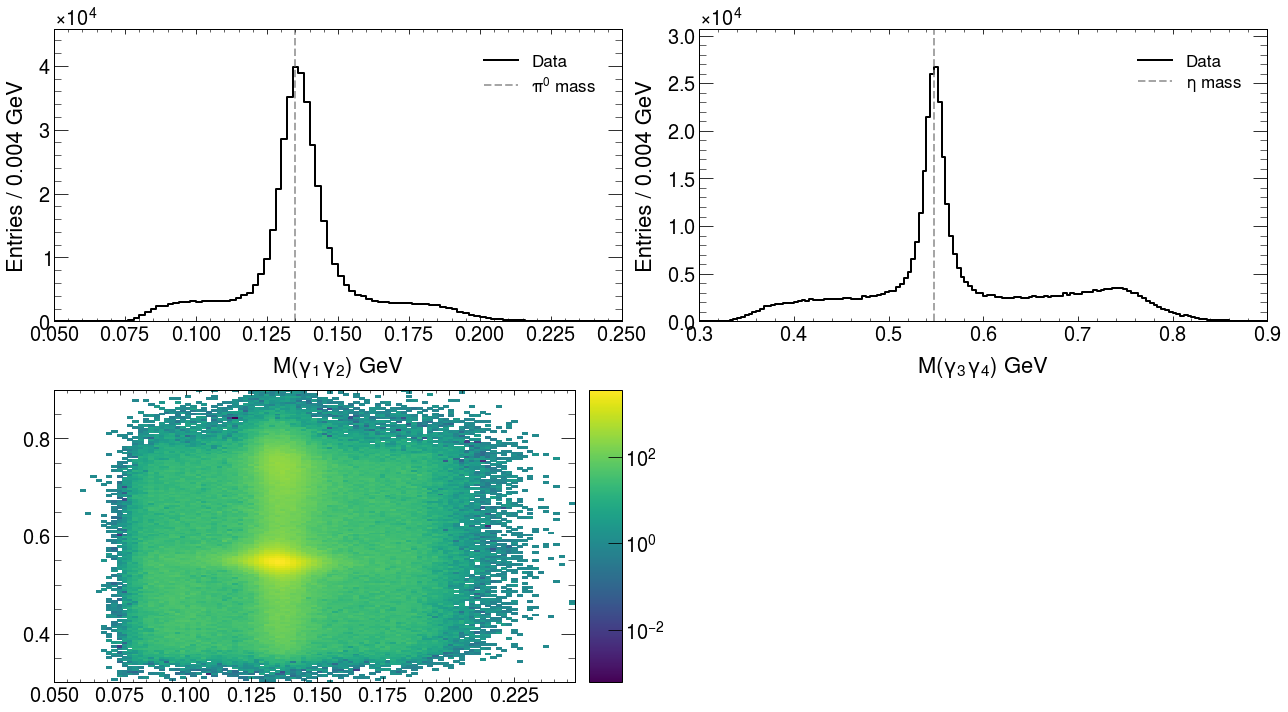

In [30]:
def plotDiagnostic2(df,axes,weights,**kwargs):
    makePlot(df,"Mpi0",0,0.3,0.002,r"$M(\gamma_1\gamma_2)$ GeV",axes[0],weights,**kwargs)
    axes[0].set_ylabel("Entries / %0.3f GeV" % (0.004))
    
    makePlot(df,"Meta",0.3,0.9,0.004,r"$M(\gamma_3\gamma_4)$ GeV",axes[1],weights,**kwargs)
    axes[1].set_ylabel("Entries / %0.3f GeV" % (0.004))

fig,axes=plt.subplots(1,2,figsize=(18,5))

weights1=df1.AccWeight
weights2=df2.AccWeight
weights3=df3.AccWeight
weights4=df4.AccWeight

weights=[weights1,weights2,weights3,weights4]
dfs=[df1,df2,df3,df4]
titles=["Total","+Proton Cuts","+Photon Cuts","+Loose Exclusivity"]
for i, label, df, weight in zip(range(4),titles,dfs,weights):
    plotDiagnostic2(df,axes,weight,label=label)

axes[0].axvline(pi0mass,c="gray",label=r"$\pi^0$ mass",linestyle='--',alpha=0.7)
axes[1].axvline(etamass,c="gray",label=r"$\eta$ mass",linestyle='--',alpha=0.7)
axes[0].legend()
axes[1].legend()
axes[0].set_yscale("log")
axes[1].set_yscale("log")
plt.savefig(resultsFolder+f"/mass_distributions_per_cut_{run_period}.pdf")

def plotDiagnostic3(df,df_mc,axes,**kwargs):
    counts=makePlot(df,"Mpi0",0.05,0.25,0.002,r"$M(\gamma_1\gamma_2)$ GeV",axes[0],weights=df.AccWeight,color='black',label="Data",setylim=True,**kwargs)[0][0]
#     makePlot(df_mc,"Mpi0",0.05,0.25,0.002,r"$M(\gamma_1\gamma_2)$ GeV",axes[0],weights=df_mc.AccWeight,scaleFactor=-1,max_counts=max(counts),color='red',label="MC")
    axes[0].set_ylabel("Entries / %0.3f GeV" % (0.004))
    
    counts=makePlot(df,"Meta",0.3,0.9,0.004,r"$M(\gamma_3\gamma_4)$ GeV",axes[1],weights=df.AccWeight,color='black',label="Data",setylim=True,**kwargs)[0][0]
#     makePlot(df_mc,"Meta",0.3,0.9,0.004,r"$M(\gamma_3\gamma_4)$ GeV",axes[1],weights=df_mc.AccWeight,scaleFactor=-1,max_counts=max(counts),color='red',label="MC")
    axes[1].set_ylabel("Entries / %0.3f GeV" % (0.004))

fig,axes=plt.subplots(2,2,figsize=(18,10))
plotDiagnostic3(df4,df4_mc,axes[0,:],c='tab:red')
hep.hist2dplot(
    np.histogram2d(df4.Mpi0,df4.Meta,weights=df4.AccWeight,bins=(np.arange(0.05,0.25,0.002),np.arange(0.3,0.9,0.004))),
    ax=axes[1,0],norm=mpl.colors.LogNorm())
# hep.hist2dplot(
#     np.histogram2d(df4_mc.Mpi0,df4_mc.Meta,weights=df4_mc.AccWeight,bins=(np.arange(0.05,0.25,0.002),np.arange(0.3,0.9,0.004))),
#     ax=axes[1,1],norm=mpl.colors.LogNorm())

axes[0,0].axvline(pi0mass,c="gray",label=r"$\pi^0$ mass",linestyle='--',alpha=0.7)
axes[0,1].axvline(etamass,c="gray",label=r"$\eta$ mass",linestyle='--',alpha=0.7)
axes[0,0].legend()
axes[0,1].legend()
axes[0,0].set_ylim(0)
axes[0,0].set_ylim(0)

# axes[1,0].set_xlabel(r"$M(\gamma_1\gamma_2)$ GeV")
# axes[1,0].set_ylabel(r"$M(\gamma_3\gamma_4)$ GeV")
# axes[1,0].legend()
# axes[1,1].set_xlabel(r"$M(\gamma_1\gamma_2)$ GeV")
# axes[1,1].set_ylabel(r"$M(\gamma_3\gamma_4)$ GeV")
# axes[1,1].legend()

axes[1,1].axis(False)

plt.tight_layout()
plt.savefig(resultsFolder+f"/exclusivity_massplots_{run_period}.pdf")

In [31]:
# fig,axes=plt.subplots(2,2,figsize=(14,10))
# axes=axes.flatten()

# doWeight=True

# for idf, title,df in zip(range(len(dfs)),titles,dfs):
#     if doWeight:
#         hep.hist2dplot(np.histogram2d(df.Mpi0,df.Meta,weights=df.AccWeight,
#                                       bins=(getBinning(0.07,0.2,0.003),getBinning(0.25,0.85,0.01))),ax=axes[idf],linewidth=0,rasterized=True)
#     else:
#         hep.hist2dplot(np.histogram2d(df.Mpi0,df.Meta,
#                                       bins=(getBinning(0.07,0.2,0.003),getBinning(0.25,0.85,0.01))),ax=axes[idf],linewidth=0,rasterized=True)
#     axes[idf].set_xlim(0.07,0.2)
#     axes[idf].set_ylim(0.25,0.85)
#     axes[idf].set_xlabel("$M(\gamma_1\gamma_2)$ Events / 0.003 GeV")
#     axes[idf].set_ylabel("$M(\gamma_3\gamma_4)$ Events / 0.01 GeV")
#     axes[idf].set_title(title)
# plt.tight_layout()
# plt.savefig(resultsFolder+"/mass_distributions_2d_per_cut.pdf")

## Most background in $\gamma_3\gamma_4$ - fit $M(\gamma_3\gamma_4)$ to get purity

In [13]:
dfs_looseChi=[]
datasets=["2017_1","2018_1","2018_8"]
for dataset in datasets:
#     fileName="/d/grid17/ln16/myDSelector/zThesisCuts/degALL_data_"+dataset+"_stdProtonPhotonExclusivity_looseChi_for_thesis_treeFlat_DSelector.root"
    fileName="/d/grid17/ln16/dselector_v3/study_eventSelections/rootFiles/looseUE/D"+dataset+"_selected_acc_flat.root"
    treeName="kin"
    cols=["Mpi0eta","weightASBS","weightBS","cosTheta_eta_gj","cosTheta_eta_hel","phi_eta_gj","phi_eta_hel",
          "Mpi0","Meta","AccWeight","chiSq","Ebeam","mandelstam_t","mandelstam_tp","Mpi0p","Metap","omegaCut","unusedEnergy",
          "proton_z",'mmsq',
         "mandelstam_teta","mandelstam_tpi0","run","event","rfTime","phi_eta_lab","phi_pi0_lab","BeamAngle",
         "photonE1","photonE2","photonE3","photonE4","photonTheta1","photonTheta2","photonTheta3","photonTheta4",
         "pVH","pVH_etap","pVH_pi0p"]
    tree=uproot.open(fileName)[treeName]
#     df=tree.arrays(cols,entrystart=0,entrystop=100000,outputtype=pd.DataFrame).reset_index(drop=True)
    df=tree.arrays(cols,outputtype=pd.DataFrame).reset_index(drop=True)
    dfs_looseChi.append(df)
    
yields=[dfs_looseChi[i].weightASBS.sum() for i in range(len(dfs_looseChi))]
yieldsFrac=[val/sum(yields) for val in yields]
for i,val in enumerate(yieldsFrac):
    print(datasets[i]+" integral: %0.2f" % val)

2017_1 integral: 0.17
2018_1 integral: 0.48
2018_8 integral: 0.35


In [14]:
def poly(x, *args):
    final=0
    for order in range(0,len(args)):
        final=final+args[order]*x**(order)
    return final

def gaussian(x, A, mu, sig):
    return A*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

def doublegaussian(x, A, B, mu, sig, sig2):
    return gaussian(x,A,mu,sig)+gaussian(x,B,mu,sig2)
    #return A*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.))) + B*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig2, 2.)))

def fit(x, A, B, mu, sig, sig2, *args):
    return doublegaussian(x,A,B,mu,sig,sig2)+poly(x,*args)

In [15]:
phase1_looseChi=pd.concat(dfs_looseChi)
# phase1_looseChi=phase1_looseChi.sample(4000000)

In [16]:
tmp=phase1_looseChi#.sample(5000000)
tmp=tmp[tmp.chiSq<13.277]
tmp=tmp[tmp.Mpi0p>1.4]

'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


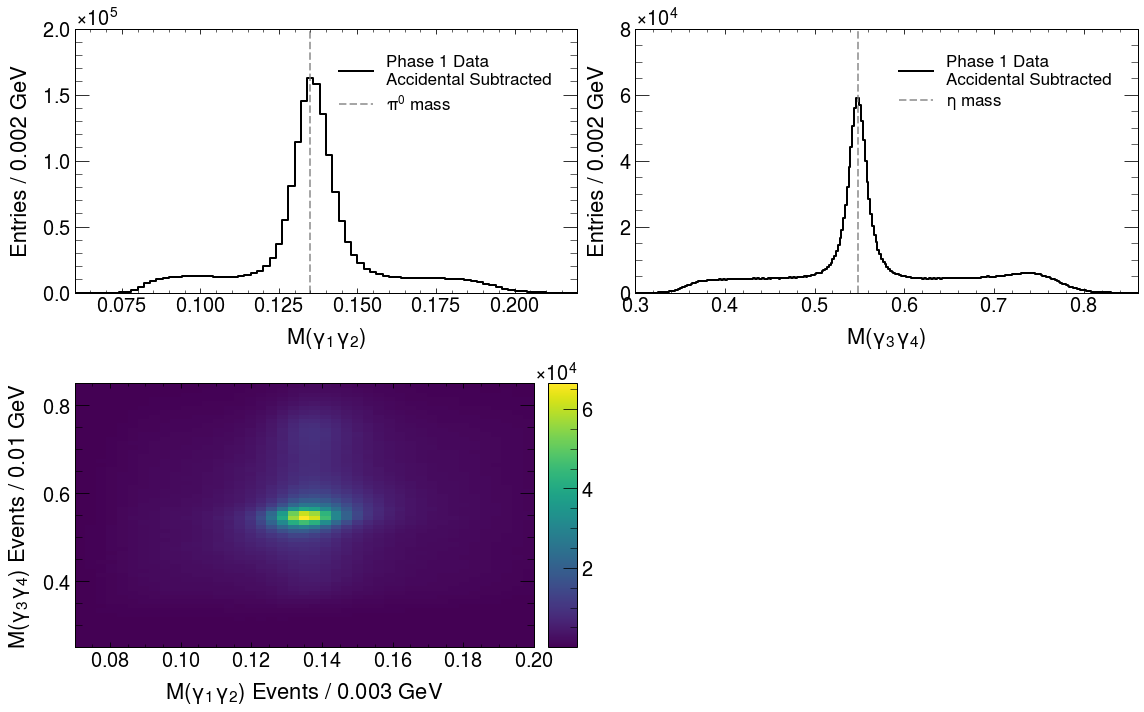

In [17]:
from matplotlib.patches import Rectangle

## sidebands
pi0Mean=0.135881
etaMean=0.548625
pi0Std=0.0076
etaStd=0.0191
pi0Sig=3
pi0Skip=1
pi0SB=1.5
etaSig=3
etaSkip=1
etaSB=2

fig,axes=plt.subplots(2,2,figsize=(16,10))
axes=axes.flatten()

mrange=(0.06,0.22)
mstep=0.002
makePlot(tmp,"Mpi0",*mrange,mstep,r"$M(\gamma_1\gamma_2)$",axes[0],tmp["AccWeight"],c='black',label="Phase 1 Data\nAccidental Subtracted")
axes[0].axvline(pi0mass,c="gray",label=r"$\pi^0$ mass",linestyle='--',alpha=0.7)
axes[0].set_ylabel("Entries / %0.3f GeV" % (mstep))
axes[0].set_ylim(bottom=0)
axes[0].legend(loc=1)

mrange=(0.3,0.86)
mstep=0.002
makePlot(tmp,"Meta",*mrange,mstep,r"$M(\gamma_3\gamma_4)$",axes[1],tmp["AccWeight"],c='black',label="Phase 1 Data\nAccidental Subtracted")
axes[1].axvline(etamass,c="gray",label=r"$\eta$ mass",linestyle='--',alpha=0.7)
axes[1].set_ylabel("Entries / %0.3f GeV" % (mstep))
axes[1].set_ylim(bottom=0)
axes[1].legend(loc=1)

hep.hist2dplot(np.histogram2d(df.Mpi0,df.Meta,bins=(getBinning(0.07,0.2,0.003),getBinning(0.25,0.85,0.01))),ax=axes[2],linewidth=0,rasterized=True,
               vmin=0.0001)#,norm=mpl.colors.LogNorm())
axes[2].set_xlim(0.07,0.2)
axes[2].set_ylim(0.25,0.85)
axes[2].set_xlabel("$M(\gamma_1\gamma_2)$ Events / 0.003 GeV")
axes[2].set_ylabel("$M(\gamma_3\gamma_4)$ Events / 0.01 GeV")

axes[3].axis(False)

plt.tight_layout()
plt.savefig(resultsFolder+"/M2g_distributions.pdf")
# plt.savefig(resultsFolder+"/mass_distributions_sidebands_shaded.pdf")
# plt.savefig(resultsFolder+"/mass_distributions_sidebands_lmac.pdf")

In [18]:
tmp=phase1_looseChi#.sample(5000000)
tmp=tmp[tmp.chiSq<13.277]

'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


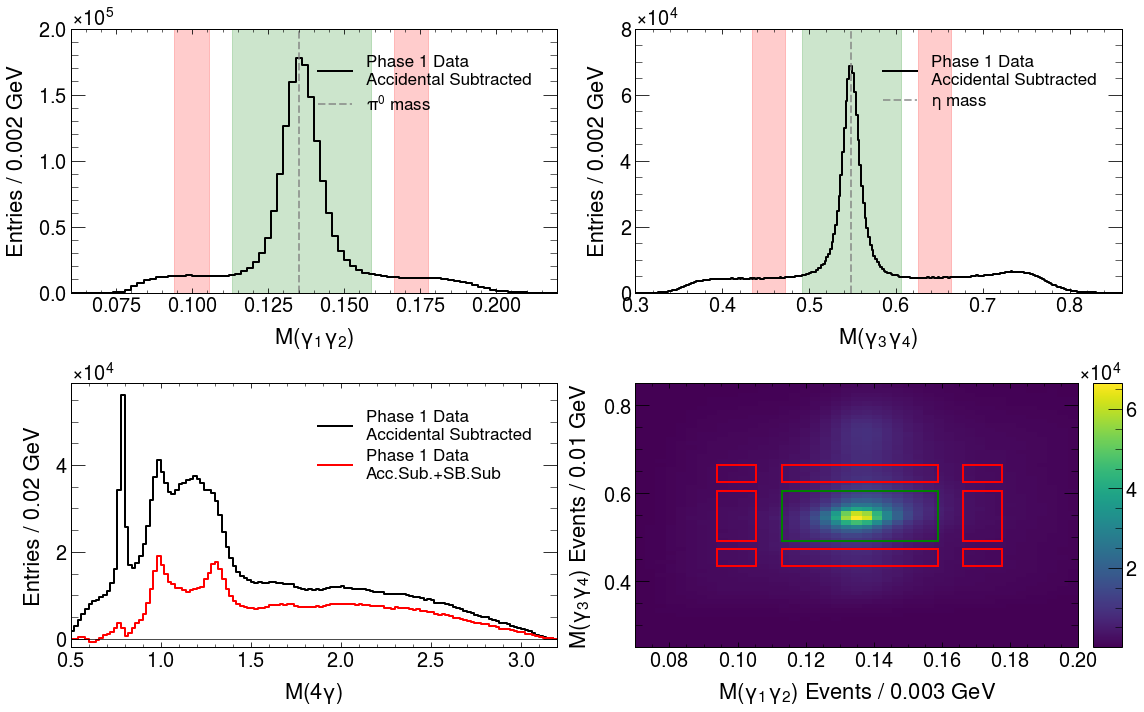

In [19]:
from matplotlib.patches import Rectangle

## sidebands
pi0Mean=0.135881
etaMean=0.548625
pi0Std=0.0076
etaStd=0.0191
pi0Sig=3
pi0Skip=1
pi0SB=1.5
etaSig=3
etaSkip=1
etaSB=2

fig,axes=plt.subplots(2,2,figsize=(16,10))
axes=axes.flatten()

mrange=(0.06,0.22)
mstep=0.002
makePlot(tmp,"Mpi0",*mrange,mstep,r"$M(\gamma_1\gamma_2)$",axes[0],tmp["AccWeight"],c='black',label="Phase 1 Data\nAccidental Subtracted")
axes[0].axvline(pi0mass,c="gray",label=r"$\pi^0$ mass",linestyle='--',alpha=0.7)
axes[0].set_ylabel("Entries / %0.3f GeV" % (mstep))
axes[0].set_ylim(bottom=0)
axes[0].legend(loc=1)
axes[0].axvspan(pi0Mean+(pi0Sig+pi0Skip)*pi0Std,pi0Mean+(pi0Sig+pi0Skip+pi0SB)*pi0Std,color='red',alpha=0.2,label='sidebands')
axes[0].axvspan(pi0Mean-(pi0Sig+pi0Skip+pi0SB)*pi0Std,pi0Mean-(pi0Sig+pi0Skip)*pi0Std,color='red',alpha=0.2)
axes[0].axvspan(pi0Mean-pi0Sig*pi0Std,pi0Mean+pi0Sig*pi0Std,color='green',alpha=0.2,label='signal')

mrange=(0.3,0.86)
mstep=0.002
makePlot(tmp,"Meta",*mrange,mstep,r"$M(\gamma_3\gamma_4)$",axes[1],tmp["AccWeight"],c='black',label="Phase 1 Data\nAccidental Subtracted")
axes[1].axvline(etamass,c="gray",label=r"$\eta$ mass",linestyle='--',alpha=0.7)
axes[1].set_ylabel("Entries / %0.3f GeV" % (mstep))
axes[1].set_ylim(bottom=0)
axes[1].legend(loc=1)
axes[1].axvspan(etaMean+(etaSig+etaSkip)*etaStd,etaMean+(etaSig+etaSkip+etaSB)*etaStd,color='red',alpha=0.2,label='sidebands')
axes[1].axvspan(etaMean-(etaSig+etaSkip+etaSB)*etaStd,etaMean-(etaSig+etaSkip)*etaStd,color='red',alpha=0.2)
axes[1].axvspan(etaMean-etaSig*etaStd,etaMean+etaSig*etaStd,color='green',alpha=0.2,label='signal')

mrange=(0.5,3.2)
mstep=0.02
count_edges=makePlot(tmp,"Mpi0eta",*mrange,mstep,r"$M(4\gamma)$",axes[2],tmp["AccWeight"],c='black',label="Phase 1 Data\nAccidental Subtracted")
_=makePlot(tmp,"Mpi0eta",*mrange,mstep,r"$M(4\gamma)$",axes[2],tmp["weightASBS"],c='red',label="Phase 1 Data\nAcc.Sub.+SB.Sub")
# _=makePlot(tmp[~tmp.omegaCut],"Mpi0eta",*mrange,mstep,r"$M(4\gamma)$",axes[2],tmp[~tmp.omegaCut]["weightASBS"],c='red',label="Phase 1 Data\nAcc.Sub. + SB.Sub\n+ LMAC cut")
axes[2].set_ylabel("Entries / %0.2f GeV" % (mstep))
axes[2].set_ylim(bottom=-2000,top=max(count_edges[0][0])*1.05)
axes[2].axhline(0,c='black',linewidth=1,alpha=0.7)
# axes[2].axvspan(1.04,1.72,color='lightgray',alpha=0.7,label='Region of\nInterest')
axes[2].legend()

hep.hist2dplot(np.histogram2d(df.Mpi0,df.Meta,bins=(getBinning(0.07,0.2,0.003),getBinning(0.25,0.85,0.01))),ax=axes[3],linewidth=0,rasterized=True,
               vmin=0.0001)#,norm=mpl.colors.LogNorm())
axes[3].set_xlim(0.07,0.2)
axes[3].set_ylim(0.25,0.85)
axes[3].set_xlabel("$M(\gamma_1\gamma_2)$ Events / 0.003 GeV")
axes[3].set_ylabel("$M(\gamma_3\gamma_4)$ Events / 0.01 GeV")

extra_args={'fill':None,'linewidth':2}
axes[3].add_patch(Rectangle((pi0Mean-pi0Sig*pi0Std, etaMean-etaSig*etaStd), 2*pi0Sig*pi0Std, 2*etaSig*etaStd,color='green',**extra_args))

axes[3].add_patch(Rectangle((pi0Mean-(pi0Sig+pi0Skip+pi0SB)*pi0Std, etaMean+(etaSig+etaSkip)*etaStd), pi0SB*pi0Std, etaSB*etaStd, color='red', **extra_args))
axes[3].add_patch(Rectangle((pi0Mean+(pi0Sig+pi0Skip)*pi0Std, etaMean+(etaSig+etaSkip)*etaStd), pi0SB*pi0Std, etaSB*etaStd, color='red', **extra_args))
axes[3].add_patch(Rectangle((pi0Mean-pi0Sig*pi0Std, etaMean+(etaSig+etaSkip)*etaStd), 2*pi0Sig*pi0Std, etaSB*etaStd, color='red', **extra_args))

axes[3].add_patch(Rectangle((pi0Mean-(pi0Sig+pi0Skip+pi0SB)*pi0Std, etaMean-(etaSig+etaSkip+etaSB)*etaStd), pi0SB*pi0Std, etaSB*etaStd, color='red', **extra_args))
axes[3].add_patch(Rectangle((pi0Mean+(pi0Sig+pi0Skip)*pi0Std, etaMean-(etaSig+etaSkip+etaSB)*etaStd), pi0SB*pi0Std, etaSB*etaStd, color='red', **extra_args))
axes[3].add_patch(Rectangle((pi0Mean-pi0Sig*pi0Std, etaMean-(etaSig+etaSkip+etaSB)*etaStd), 2*pi0Sig*pi0Std, etaSB*etaStd, color='red', **extra_args))

axes[3].add_patch(Rectangle((pi0Mean-(pi0Sig+pi0Skip+pi0SB)*pi0Std, etaMean-etaSig*etaStd), pi0SB*pi0Std, 2*etaSig*etaStd, color='red', **extra_args))
axes[3].add_patch(Rectangle((pi0Mean+(pi0Sig+pi0Skip)*pi0Std, etaMean-etaSig*etaStd), pi0SB*pi0Std, 2*etaSig*etaStd, color='red', **extra_args))


plt.tight_layout()
plt.savefig(resultsFolder+"/mass_distributions_sidebands.pdf")
# plt.savefig(resultsFolder+"/mass_distributions_sidebands_shaded.pdf")
# plt.savefig(resultsFolder+"/mass_distributions_sidebands_lmac.pdf")

In [20]:
def addText(value, string, counts, edges, ax):
    ''' Add string above the value that is located in a bin defined by edges'''
    count=counts[np.where(value<edges)[0][0]]
    ax.text(x=value, y=count*1.1, s=string, size=20)

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


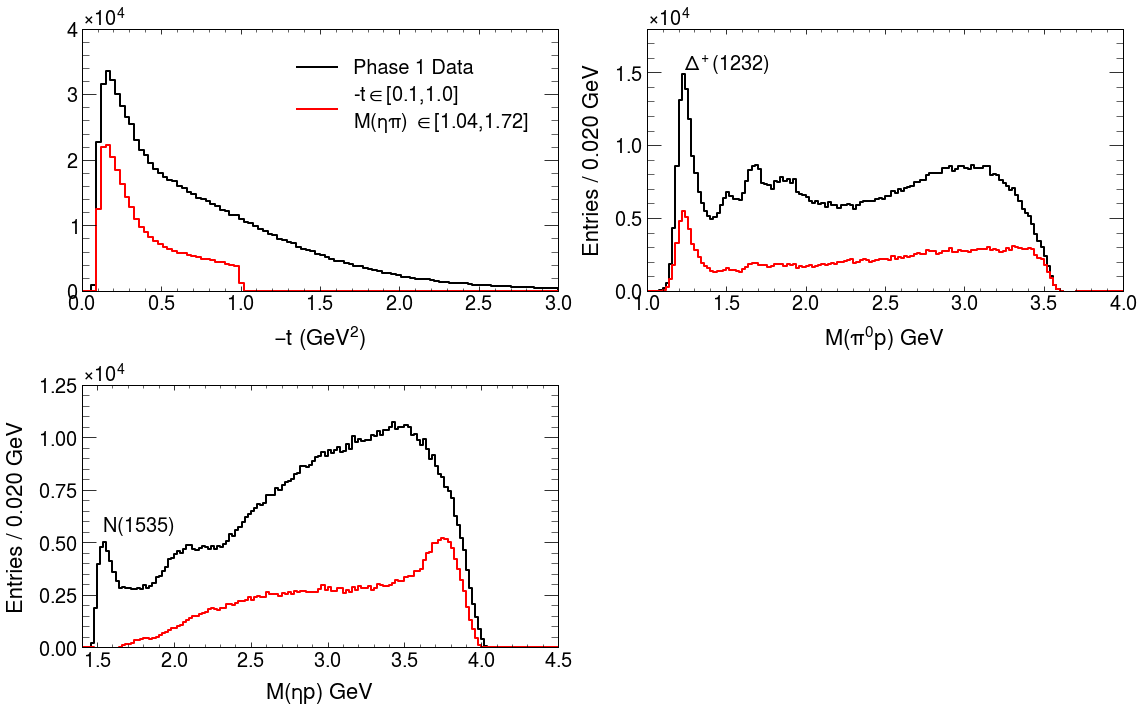

In [21]:
####################
# BARYON PLOTS
####################

tmp=tmp[tmp.omegaCut]

fig,axes=plt.subplots(2,2,figsize=(16,10))
axes=axes.flatten()
fig.delaxes(axes[3])

makePlot(tmp,"mandelstam_t",0,3,0.03,r"$-t~(GeV^2)$",axes[0],tmp["weightASBS"],c='black',label="Phase 1 Data")
makePlot(tmp[(tmp.mandelstam_t>0.1)&(tmp.mandelstam_t<1.0)&(tmp.Mpi0eta>1.04)&(tmp.Mpi0eta<1.72)],"mandelstam_t",0,3,0.03,r"$-t~(GeV^2)$",axes[0],
         tmp.loc[(tmp.mandelstam_t>0.1)&(tmp.mandelstam_t<1.0)&(tmp.Mpi0eta>1.04)&(tmp.Mpi0eta<1.72),"weightASBS"],c='red',
         label="-t$\in$[0.1,1.0]\n$M(\eta\pi)$ $\in$[1.04,1.72]")
# makePlot(tmp[(tmp.Mpi0eta>1.60)&(tmp.Mpi0eta<2.80)],"mandelstam_t",0,3,0.03,r"$-t~(GeV^2)$",axes[0],
#          tmp.loc[(tmp.Mpi0eta>1.60)&(tmp.Mpi0eta<2.80),"weightASBS"],c='royalblue',
#          label="$M(\eta\pi)$ $\in$[1.6,2.8]")
# axes[0].set_ylabel("Entries / %0.3f GeV" % (0.03))
axes[0].set_ylim(bottom=0)
axes[0].legend(prop={"size":20})

(counts, edges), scaleFactor=makePlot(tmp,"Mpi0p",1.0,4.0,0.02,r"$M(\pi^0 p)$ GeV",axes[1],tmp["weightASBS"],c='black',label="Phase 1 Data")
makePlot(tmp[(tmp.mandelstam_t>0.1)&(tmp.mandelstam_t<1.0)&(tmp.Mpi0eta>1.04)&(tmp.Mpi0eta<1.72)],"Mpi0p",1.0,4.0,0.02,r"$M(\pi^0 p)$ GeV",axes[1],
         tmp.loc[(tmp.mandelstam_t>0.1)&(tmp.mandelstam_t<1.0)&(tmp.Mpi0eta>1.04)&(tmp.Mpi0eta<1.72),"weightASBS"],c='red')
# makePlot(tmp[(tmp.Mpi0eta>1.60)&(tmp.Mpi0eta<2.8)],"Mpi0p",1.0,4.0,0.02,r"$M(\pi^0 p)$ GeV",axes[1],
#          tmp.loc[(tmp.Mpi0eta>1.60)&(tmp.Mpi0eta<2.8),"weightASBS"],c='royalblue')
axes[1].set_ylabel("Entries / %0.3f GeV" % (0.02))
axes[1].set_ylim(bottom=0,top=18000)
addText(1.232,r"$\Delta^+(1232)$",counts, edges, axes[1])
# axes[1].legend()

(counts, edges), scaleFactor=makePlot(tmp,"Metap",1.4,4.5,0.02,r"$M(\eta p)$ GeV",axes[2],tmp["weightASBS"],c='black',label="Phase 1 Data")
makePlot(tmp[(tmp.mandelstam_t>0.1)&(tmp.mandelstam_t<1.0)&(tmp.Mpi0eta>1.04)&(tmp.Mpi0eta<1.72)],"Metap",1.4,4.5,0.02,r"$M(\eta p)$ GeV",axes[2],
         tmp.loc[(tmp.mandelstam_t>0.1)&(tmp.mandelstam_t<1.0)&(tmp.Mpi0eta>1.04)&(tmp.Mpi0eta<1.72),"weightASBS"],c='red')
# makePlot(tmp[(tmp.Mpi0eta>1.60)&(tmp.Mpi0eta<2.8)],"Metap",1.4,4.5,0.02,r"$M(\eta p)$ GeV",axes[2],
#          tmp.loc[(tmp.Mpi0eta>1.60)&(tmp.Mpi0eta<2.8),"weightASBS"],c='royalblue')
axes[2].set_ylabel("Entries / %0.3f GeV" % (0.02))
axes[2].set_ylim(bottom=0)
addText(1.535,r"$N(1535)$",counts, edges, axes[2])
# axes[2].legend(bbox_to_anchor=(1.1,1),prop={"size":24})


plt.tight_layout()
# plt.savefig(resultsFolder+"/baryon_plots.pdf")
plt.savefig(resultsFolder+"/baryon_plots_noDRregion.pdf")

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
Substituting with a symbol from Computer Modern.


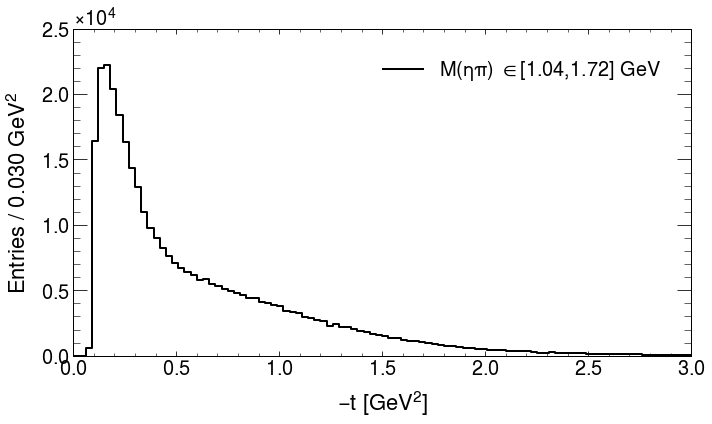

In [32]:
fig,axes=plt.subplots(1,1,figsize=(10,6))
axes=[axes]

makePlot(tmp[(tmp.Mpi0eta>1.04)&(tmp.Mpi0eta<1.72)],"mandelstam_t",0,3,0.03,r"$-t~[GeV^2]$",axes[0],
         tmp.loc[(tmp.Mpi0eta>1.04)&(tmp.Mpi0eta<1.72),"weightASBS"],c='black',
         label="$M(\eta\pi)$ $\in$[1.04,1.72] GeV")
axes[0].set_ylabel("Entries / %0.3f $GeV^2$" % (0.03))
axes[0].set_ylim(bottom=0)
axes[0].legend(prop={"size":20})

plt.tight_layout()
plt.savefig(resultsFolder+"/mandelstam_t_noDRregion.pdf")

'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


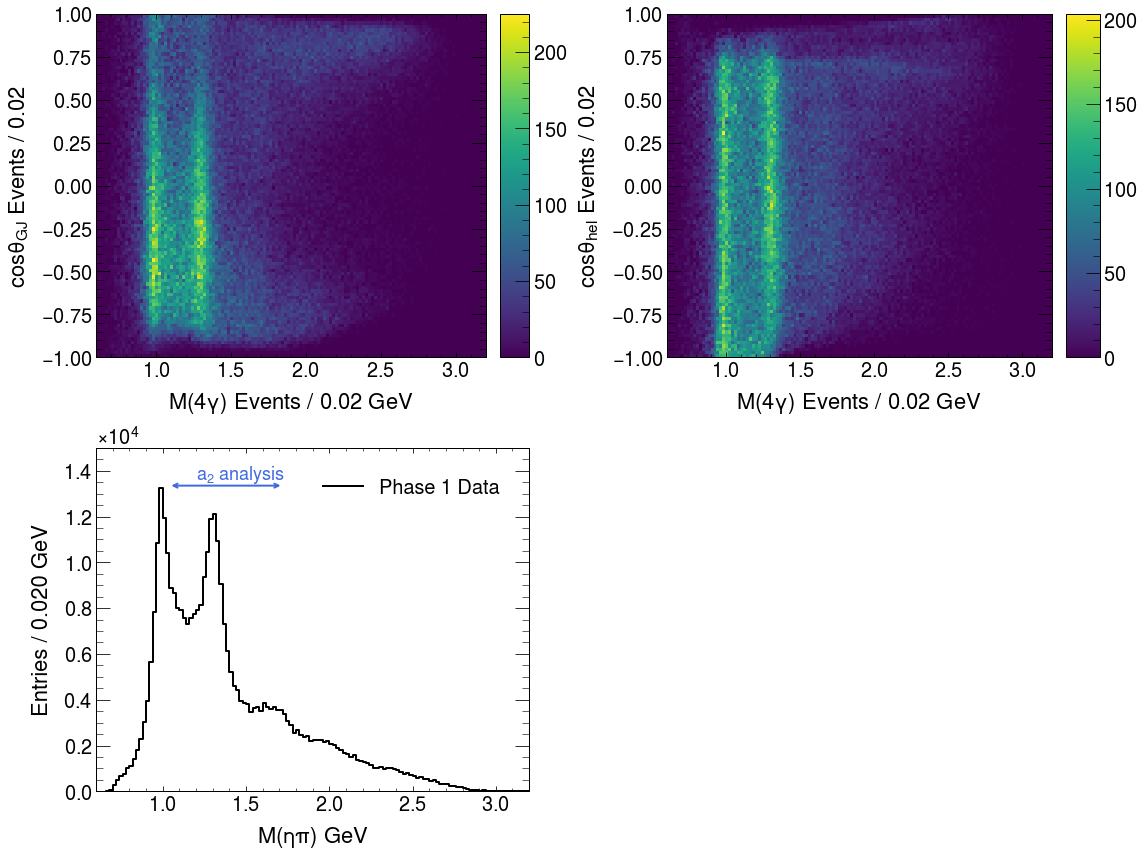

In [98]:
tmp=phase1_looseChi
tmp=tmp[tmp.chiSq<13.277]
tmp=tmp[tmp.omegaCut]
tmp=tmp[tmp.pVH]
tmp=tmp[(tmp.mandelstam_t>0.1)&(tmp.mandelstam_t<1.0)]

# vmin=0.0001
vmin=0

fig,axes=plt.subplots(2,2,figsize=(16,12))
axes=axes.flatten()

mrange=(0.6,3.2)
mstep=0.02
makePlot(tmp,"Mpi0eta",*mrange,mstep,r"$M(\eta\pi)$ GeV",axes[2],tmp["weightASBS"],c='black',label="Phase 1 Data")
axes[2].set_ylabel("Entries / %0.3f GeV" % (mstep))
axes[2].set_ylim(bottom=0)
axes[2].set_xlim(*mrange)


def getFrac(m,mrange):
    l,u=mrange
    return (m-l)/(u-l)
######################################
### annotate a2 region ###
axes[2].annotate("",
            xy=(getFrac(1.04,mrange),0.89), xycoords='axes fraction',
            xytext=(getFrac(1.72,mrange), 0.89), textcoords='axes fraction',
            arrowprops=dict(arrowstyle="<->",
                            connectionstyle="arc3", color='royalblue', lw=2)
            )
axes[2].text(getFrac(1.2,mrange), 0.91, r'$a_2$ analysis',fontsize = 18,transform=axes[2].transAxes,c='royalblue')
######################################
### annotate DREx region ###
# axes[2].annotate("",
#             xy=(getFrac(1.6,mrange),0.75), xycoords='axes fraction',
#             xytext=(getFrac(3.0,mrange), 0.75), textcoords='axes fraction',
#             arrowprops=dict(arrowstyle="<->",
#                             connectionstyle="arc3", color='r', lw=2)
#             )
# axes[2].text(getFrac(2.0,mrange), 0.77, 'DREx analysis',fontsize = 18,transform=axes[2].transAxes,c='red')
######################################
# axes[2].axvspan(1.04,1.80,color='royalblue',alpha=0.4,label=r"$a_2$ analysis")
# axes[2].axvspan(1.60,3.0,color='orange',alpha=0.4,label=r"DREx analysis")
axes[2].legend(prop={"size":20})


hep.hist2dplot(np.histogram2d(tmp.Mpi0eta,tmp.cosTheta_eta_gj,weights=tmp.weightASBS,
                              bins=(getBinning(*mrange,mstep),getBinning(-1,1,0.02))),ax=axes[0],linewidth=0,rasterized=True,
               vmin=vmin)
axes[0].set_xlim(*mrange)
axes[0].set_ylim(-1,1)
axes[0].set_xlabel(f"$M(4\gamma)$ Events / {mstep} GeV")
axes[0].set_ylabel(r"$cos\theta_{GJ}$ Events / 0.02")

plt.tight_layout()

hep.hist2dplot(np.histogram2d(tmp.Mpi0eta,tmp.cosTheta_eta_hel,weights=tmp.weightASBS,
                              bins=(getBinning(*mrange,mstep),getBinning(-1,1,0.02))),ax=axes[1],linewidth=0,rasterized=True,
               vmin=vmin)
axes[1].set_xlim(*mrange)
axes[1].set_ylim(-1,1)
axes[1].set_xlabel(f"$M(4\gamma)$ Events / {mstep} GeV")
axes[1].set_ylabel(r"$cos\theta_{hel}$ Events / 0.02")

axes[3].axis(False)

plt.tight_layout()

plt.savefig(resultsFolder+"/final_M4g_and_cosM4g_a2_note.pdf")
# plt.savefig(resultsFolder+"/final_M4g_and_cosM4g.pdf")

# t-bin centers vs weighted center

In [133]:
tmins=[0.1,0.2,0.325,0.5,0.75]
tmaxs=[0.2,0.325,0.5,0.75,1.0]
tmids=[0.15,0.2625,0.4125,0.625,0.875]
counts,edges=np.histogram(tmp.mandelstam_t,weights=tmp.weightASBS,bins=500)
centers=edges[1:]+(edges[1]-edges[0])/2

0.1<t<0.2: 0.152
0.2<t<0.325: 0.258
0.325<t<0.5: 0.406
0.5<t<0.75: 0.620
0.75<t<1.0: 0.869


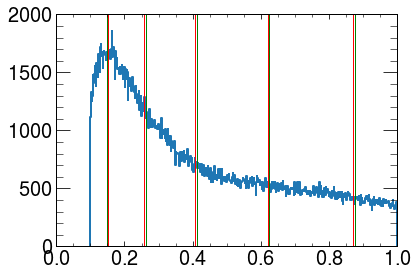

In [134]:
t_bin_centers=[]
hep.histplot((counts,edges))
for tmin, tmax in zip(tmins,tmaxs):
    idxs=np.where((tmin<centers)&(centers<tmax))
    integral_in_tBin=counts[idxs].sum()
    t_bin_center=np.sum(counts[idxs]*centers[idxs])/integral_in_tBin
    plt.axvline(t_bin_center,c='red',linewidth=1)
    print(f'{tmin}<t<{tmax}: {t_bin_center:0.3f}')
[plt.axvline(tmid,c='green',linewidth=1) for tmid in tmids]

## Segue to Combinatorics in Data to introduce accidental subtraction
### Since there could be correlations between beam photon combinatorics and the chiSq threshold selection

In [27]:
phase1_looseChi=phase1_looseChi[(phase1_looseChi.Ebeam>8.2)&(phase1_looseChi.Ebeam<8.8)]

In [28]:
phase1_looseChi["kindOfUniqueID"]=phase1_looseChi["run"].astype(str)+"_"+phase1_looseChi["event"].astype(str)

(0.0, 1.2)

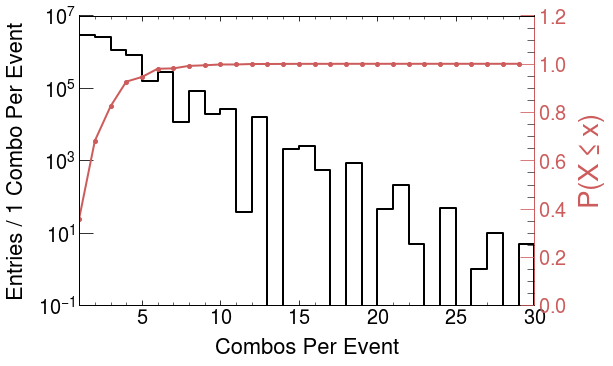

In [29]:
plt.figure(figsize=(8,5))
comboCount=phase1_looseChi.kindOfUniqueID.value_counts().values
hComboCount=np.histogram(comboCount,bins=getBinning(comboCount.min(),comboCount.max(),1))
hep.histplot(hComboCount,color='black')
plt.xlim(comboCount.min(),comboCount.max())
plt.yscale("log")
plt.xlabel("Combos Per Event")
plt.ylabel("Entries / 1 Combo Per Event")

ax=plt.twinx()
cdfx=range(1,int(hComboCount[1][-1]))
cdfy=[sum(hComboCount[0][hComboCount[1][:-1]<=i]) for i in cdfx]
cdfy=cdfy/cdfy[-1]
plt.plot(cdfx,cdfy,marker='.',c='indianred')
ax.spines["right"].set_edgecolor('indianred')
ax.tick_params(axis='y', colors='indianred')
ax.set_ylabel(r"P(X$\leq$x)",size=28,c='indianred')
ax.set_ylim(bottom=0)

'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


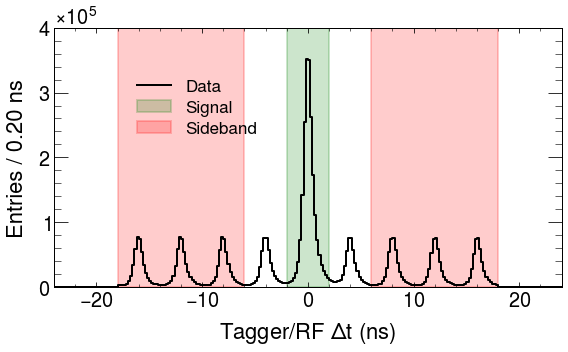

In [30]:
fig,axes=plt.subplots(1,1,figsize=(8,5))
axes=[axes]

makePlot(tmp,"rfTime",-24,24,0.2,"Tagger/RF $\Delta t$ (ns)",axes[0],[1]*len(tmp),c='black',alpha=1,label="Data")
axes[0].axvspan(-2,2,label="Signal",linewidth=2,color='green',alpha=0.2)
axes[0].axvspan(6,18,label="Sideband",linewidth=2,color='red',alpha=0.2)
axes[0].axvspan(-18,-6,color='red',linewidth=2,alpha=0.2)
axes[0].set_ylabel("Entries / %0.2f ns" % (0.2))
axes[0].legend(bbox_to_anchor=(0.45,0.9))#prop={"size":24})

plt.tight_layout()
plt.savefig(resultsFolder+"/rf_time_subtraction.pdf")

# Extract significance metrics

In [31]:
def poly(x, a, b, c):
    return a+b*x+c*x**2

def gaussian(x, A, mu, sig):
    return A*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

def doublegaussian(x, A, B, mu, sig, sig2):
    return gaussian(x,A,mu,sig)+gaussian(x,B,mu,sig2)
    #return A*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.))) + B*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig2, 2.)))

def fit(x, A, B, mu, sig, sig2, a, b, c):
    return doublegaussian(x,A,B,mu,sig,sig2)+poly(x,a,b,c)
# def fit(x, A, mu, sig, a, b, c):
#     return gaussian(x,A,mu,sig)+poly(x,a,b,c)

In [32]:
def extractSignificance(df,weight,binning,chiSqThresholds,axes,iax,region):    
    out=np.histogram(df["Meta"],weights=weight,bins=binning)
    ax=axes[iax]
    width=out[1][1]-out[1][0]
    centers=out[1][:-1]+(out[1][1]-out[1][0])/2
    hep.histplot(out,color='gray',label="Data",ax=ax)

    minrange=0.4
    if region==0:
        #### ACCIDENTAL SUBTRACTION
        constTerms=np.linspace(5000,2000,len(chiSqThresholds)) # np.linspace(10000,100,len(chiSqThresholds))
        ampTerms=np.linspace(10000,10000,len(chiSqThresholds))
        maxrange=0.75
    elif region==1:
        #### ACCIDENTAL SUBTRACTION AND 1.04<MPI0ETA<1.72
        constTerms=np.linspace(2500,2000,len(chiSqThresholds)) # np.linspace(10000,100,len(chiSqThresholds))
        ampTerms=np.linspace(5000,8000,len(chiSqThresholds))
        maxrange=0.75
    elif region==2:
        #### ACCIDENTAL SUBTRACTION AND MPI0ETA>1.6 but <2.8
        constTerms=np.linspace(2500,500,len(chiSqThresholds)) # np.linspace(10000,100,len(chiSqThresholds))
        ampTerms=np.linspace(5000,2000,len(chiSqThresholds))
        maxrange=0.74

    yields_in_region=out[0][(centers>minrange)&(centers<maxrange)]
    centers_in_region=centers[(centers>minrange)&(centers<maxrange)]
    
    try:
        popt, pcov = curve_fit(fit,centers_in_region,yields_in_region,p0=(ampTerms[iax],ampTerms[iax],0.55,0.05,0.05,constTerms[iax],0,0))
        #print(popt)
        ax.plot(centers_in_region,fit(centers_in_region, *popt),color='steelblue',label="Gaus+Poly")
        ax.plot(centers_in_region,poly(centers_in_region, *popt[5:]),color='red',linestyle='--',label="Poly")
        ax.plot(centers_in_region,doublegaussian(centers_in_region, *popt[:5]),color='green',linestyle='--',label="Gaus")
        
        sig_yield1=quad(gaussian, popt[2]-3*abs(popt[3]), popt[2]+3*abs(popt[3]), args=(popt[0],popt[2],popt[3]))[0]
        sig_yield2=quad(gaussian, popt[2]-3*abs(popt[4]), popt[2]+3*abs(popt[4]), args=(popt[1],popt[2],popt[4]))[0]
        weightedSigma = sig_yield1/(sig_yield1+sig_yield2)*abs(popt[3])+sig_yield2/(sig_yield1+sig_yield2)*abs(popt[4])
        integral_minrange=popt[2]-3*abs(weightedSigma)
        integral_maxrange=popt[2]+3*abs(weightedSigma)
        ax.axvline(integral_minrange,c='orange',linestyle='dotted')
        ax.axvline(integral_maxrange,c='orange',linestyle='dotted')
        bkg_yield=quad(poly, integral_minrange, integral_maxrange, args=tuple(popt[5:]))[0]
        sig_yield=quad(doublegaussian, integral_minrange, integral_maxrange, args=tuple(popt[:5]))[0]
        tot_yield=quad(fit, integral_minrange, integral_maxrange, args=tuple(popt))[0]
        bkg_yield/=width
        sig_yield/=width
        tot_yield/=width
        purity=sig_yield/(sig_yield+bkg_yield)
        significance_sb=sig_yield/np.sqrt(sig_yield+bkg_yield)
        significance_b=sig_yield/np.sqrt(bkg_yield)
        significance_sbb=2*(np.sqrt(sig_yield+bkg_yield)-np.sqrt(bkg_yield))
        significance_cl=np.sqrt(2*(sig_yield+bkg_yield)*np.log(1+sig_yield/bkg_yield)-2*sig_yield)
        ax.text(0.05,0.35,"Within 3$\sigma$\n--------------\nSignal Yield: %0.0fk\nBkg Yield:%0.0fk\nPurity: %0.2f\ns/sqrt(s+b): %0.0f\ns/sqrt(b): %0.0f" % (sig_yield/1000,bkg_yield/1000,
                                                                                                                                 purity,significance_sb,significance_b),size=14,transform=ax.transAxes)
    except:
        print("One iteration failed")
        return 0,0,0,0,0,0,0
    ax.set_title("$\chi^2$ < %0.2f"%chiSqThresholds[iax])
    ax.legend(prop={"size":14},loc=1)
    ax.set_ylim(bottom=0)
    if iax in [15,16,17,18]:
        ax.set_xlabel("$M(\gamma_3\gamma_4)$")
    if iax in [0,4,8,12,16,20]:
        ax.set_ylabel("Events / %0.3f GeV" % width)
    return sig_yield, bkg_yield, purity, significance_sb, significance_b, significance_sbb, significance_cl
    
    
    
def makeYieldFits(region,chiSqThresholds):
    fig,axes=plt.subplots(5,4,figsize=(22,20),sharex=True)
    axes=axes.flatten()
    
    ########################
    # Apply any cuts to phase1_looseChi for testing purposes. i.e. if you want to compare the significance plots in the resonance vs the DR region
    ########################
    if region==0:
        phase1_looseChi_copy=phase1_looseChi[(phase1_looseChi.Mpi0p>1.4)]
    elif region==1:
        phase1_looseChi_copy=phase1_looseChi[
            (phase1_looseChi.Mpi0eta>1.04)&(phase1_looseChi.Mpi0eta<1.72)
            &(phase1_looseChi.Mpi0p>1.4)
#             &(phase1_looseChi.mandelstam_t>0.1)&(phase1_looseChi.mandelstam_t<1.0)
                                            ]
    elif region==2:
        phase1_looseChi_copy=phase1_looseChi[(phase1_looseChi.Mpi0eta>1.6)&(phase1_looseChi.Mpi0eta<2.8)
                                            &(phase1_looseChi.Mpi0p>1.4)]

    binning=getBinning(phase1_looseChi_copy["Meta"].min(),phase1_looseChi_copy["Meta"].max()-0.2,0.006)
    sig_yields=[]
    bkg_yields=[]
    puritys=[]
    significances_sb=[]
    significances_b=[]
    significances_sbb=[]
    significances_cl=[]
    for iax, chiSqThreshold in enumerate(chiSqThresholds):
        if chiSqThreshold in chiSqThresholds:#chiSqThresholds:#[-2:]:
            tmp_df=phase1_looseChi_copy[(phase1_looseChi_copy.chiSq<chiSqThreshold)]
            weight=tmp_df.AccWeight        
            sig_yield, bkg_yield, purity, significance_sb, significance_b, significance_sbb, significance_cl = extractSignificance(
                tmp_df,weight,binning,chiSqThresholds,axes,iax,region)
            sig_yields.append(sig_yield)
            bkg_yields.append(bkg_yield)
            puritys.append(purity)
            significances_sb.append(significance_sb)
            significances_b.append(significance_b)
            significances_sbb.append(significance_sbb)
            significances_cl.append(significance_cl)
            
        axes[iax].set_xlim(0.2,0.9)
            
    for iax in range(len(chiSqThresholds),5*4):
        axes[iax].axis(False)
            
    plt.tight_layout()
    
    if region==0:
        plt.savefig(resultsFolder+"/Meta_fits_get_purity_Mpi0etaIntegrated.pdf")
    elif region==1:
        plt.savefig(resultsFolder+"/Meta_fits_get_purity_Mpi0etaGT104LT18.pdf")
    elif region==2:
        plt.savefig(resultsFolder+"/Meta_fits_get_purity_Mpi0etaGT16LT28.pdf")
    
    return (puritys, sig_yields, significances_sb, significances_b, significances_sbb, significances_cl)
    

In [33]:
def standardize_array(array):
    if type(array)==list:
        array=np.array(array)
    return (array-array.min())/(array.max()-array.min())

def polyH(x, a, b, c, d, e, f, g):
    return a+b*x+c*x**2+d*x**3+e*x**4+f*x**5+g*x**6

def polyHderiv(x, a, b, c, d, e):
    return b+2*c*x+3*d*x**2+4*e*x**3+5*f*x**4+6*g*x**5

def makeSignificancePlot(region,significances,chiSqThresholds):
    puritys, sig_yields, significances_sb, significances_b, significances_sbb, significances_cl = significances
    fig,axes=plt.subplots(1,2,figsize=(18,6),gridspec_kw={'width_ratios': [1, 2]})

    axes[0].scatter(chiSqThresholds,puritys,color="none", edgecolor="steelblue",linewidth=3)
    axes[0].set_xlabel("$\chi^2$",fontname="stix",size=30)
    axes[0].set_ylim((0,axes[0].get_ylim()[1]*1.1))
    axes[0].set_ylabel(r"$\frac{signal}{signal+bkg}$",size=30,c="steelblue")
    axes[0].tick_params(axis='y', colors='steelblue')

    axes02=axes[0].twinx()
    axes02.scatter(chiSqThresholds,sig_yields,color='indianred',marker='x',linewidth=3)
    axes02.spines["right"].set_edgecolor('indianred')
    axes02.tick_params(axis='y', colors='indianred')
    axes02.set_ylabel(r"Signal Yield",size=24,c='indianred')
    axes02.set_ylim((0,axes02.get_ylim()[1]*1.1))

    NDF=4
    axes[0].axvline(13.277,c='black',linestyle='--',label='selected threshold')

    h1, l1 = axes[0].get_legend_handles_labels()
    h2, l2 = axes02.get_legend_handles_labels()
    axes[0].legend(h2+h1, l2+l1, loc=4)

#     axes[1].scatter(chiSqThresholds,standardize_array(significances_sb),marker='o',alpha=0.8,
#                  s=80,facecolor='steelblue',edgecolor='steelblue',label=r"$\frac{s}{\sqrt{s+b}}$")
#     axes[1].scatter(chiSqThresholds,standardize_array(significances_b),edgecolor='indianred',marker='d',alpha=0.8,
#                  s=80,facecolor='indianred',label=r"$\frac{s}{\sqrt{b}}$")
#     axes[1].scatter(chiSqThresholds,standardize_array(significances_sbb),edgecolor='forestgreen',marker='^',
#                  alpha=0.8,facecolor='forestgreen',s=80,label=r"$2\left(\sqrt{s+b}-\sqrt{b}\ \ \right)$")
    axes[1].scatter(chiSqThresholds,standardize_array(significances_cl),color='black',s=80,
                 alpha=0.8,facecolor='black',label=r"$\sqrt{2(s+b)ln(1+\frac{s}{b})-2s}$")


    axes[1].axvline(13.277,c='black',linestyle='--',label='p-value=0.01')
    axes[1].set_ylabel("Arbitrary Units")
    axes[1].legend(loc="lower center")
    axes[1].set_xlabel("$\chi^2$",fontname="stix",size=30)

    plt.tight_layout()
    
    if region==0:
        axes[1].set_title(r"Significance Metrics : All $M(\eta\pi^0)$",size=24)
        plt.savefig(resultsFolder+"/significance_vs_chiSqCut_Mpi0etaIntegrated.pdf")
    elif region==1:
        axes[1].set_title(r"Significance Metrics : 1.04 < $M(\eta\pi^0)$ < 1.72 GeV",size=24)
        plt.savefig(resultsFolder+"/significance_vs_chiSqCut_Mpi0etaGT104LT18.pdf")
    elif region==2:
        axes[1].set_title(r"Significance Metrics : 1.60 < $M(\eta\pi^0)$ < 2.8 GeV",size=24)
        plt.savefig(resultsFolder+"/significance_vs_chiSqCut_Mpi0etaGT16LT28.pdf")

'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


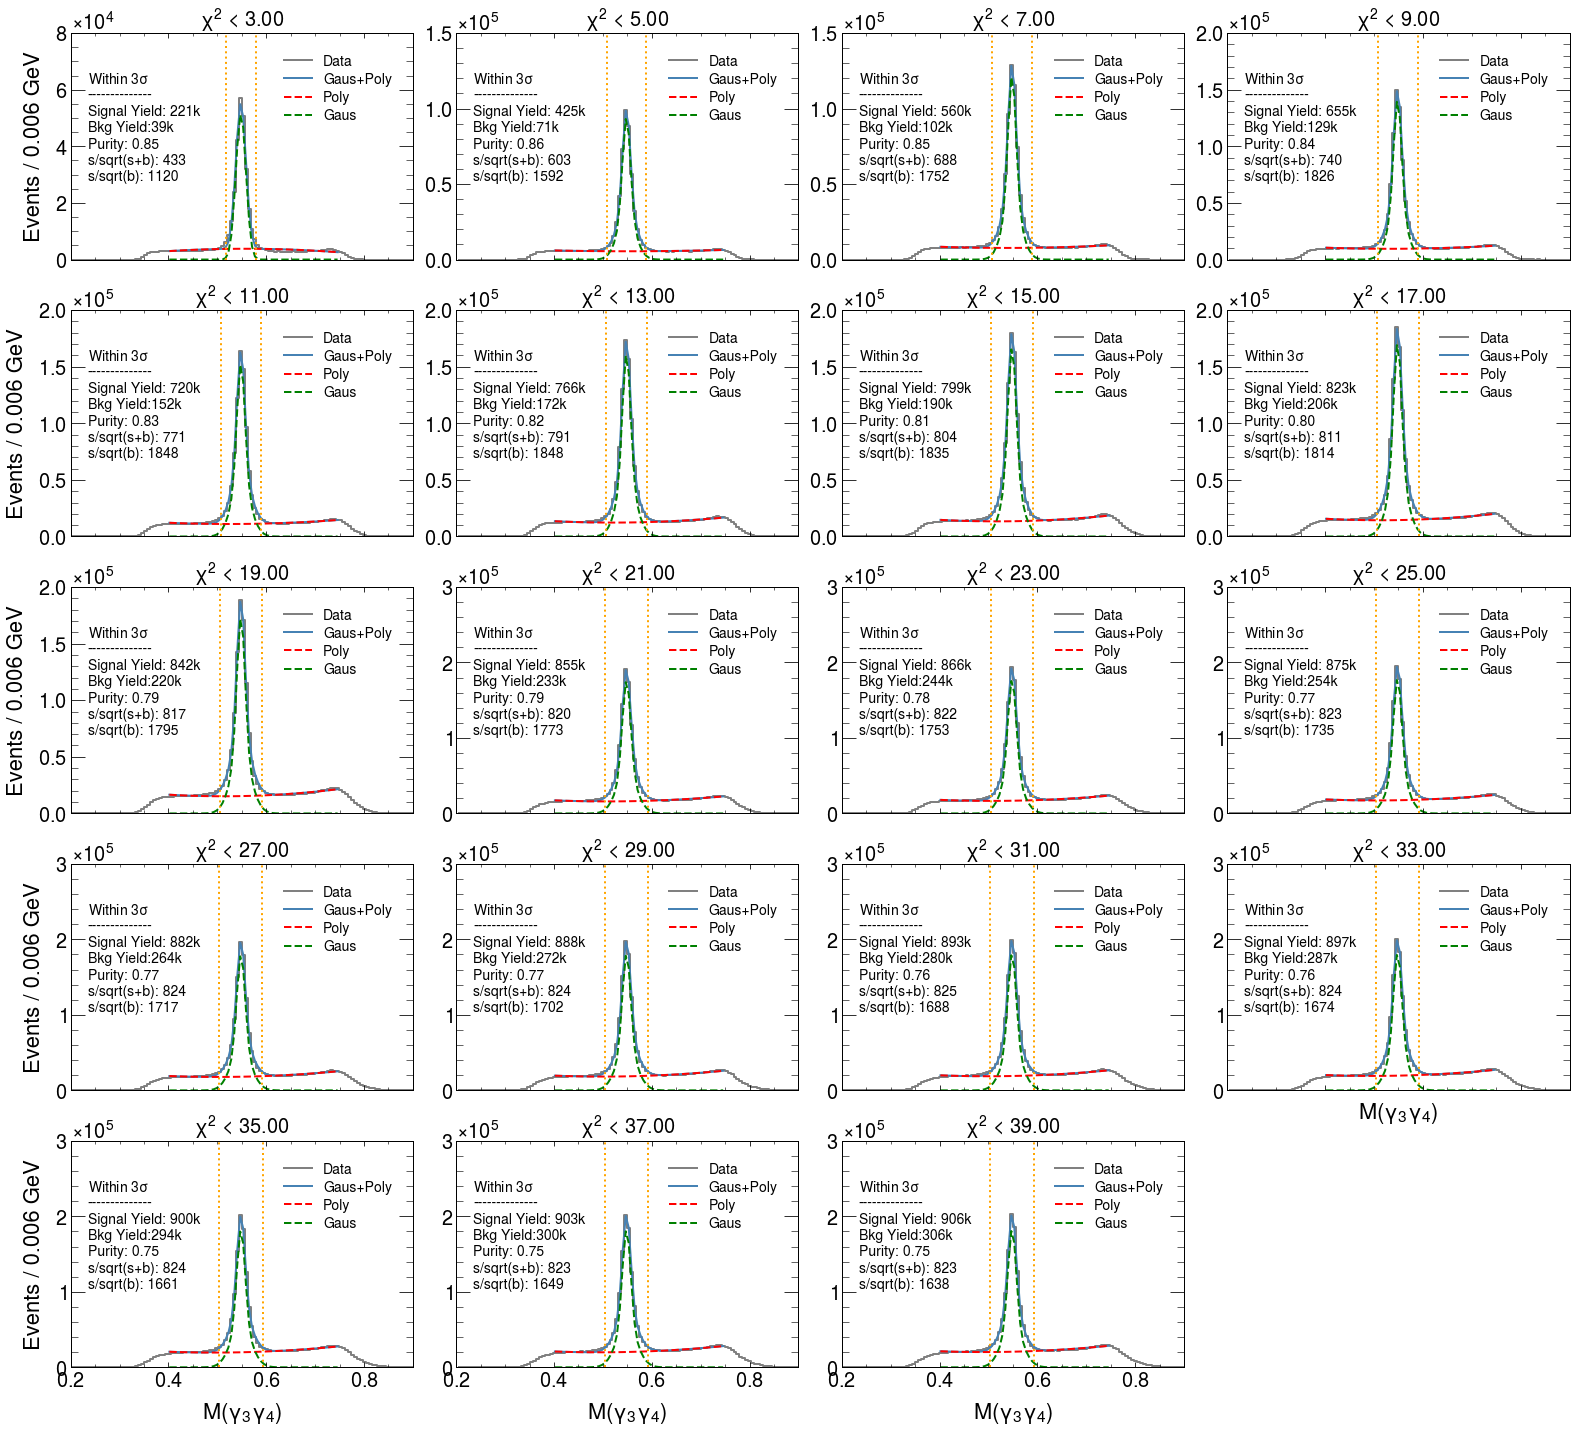

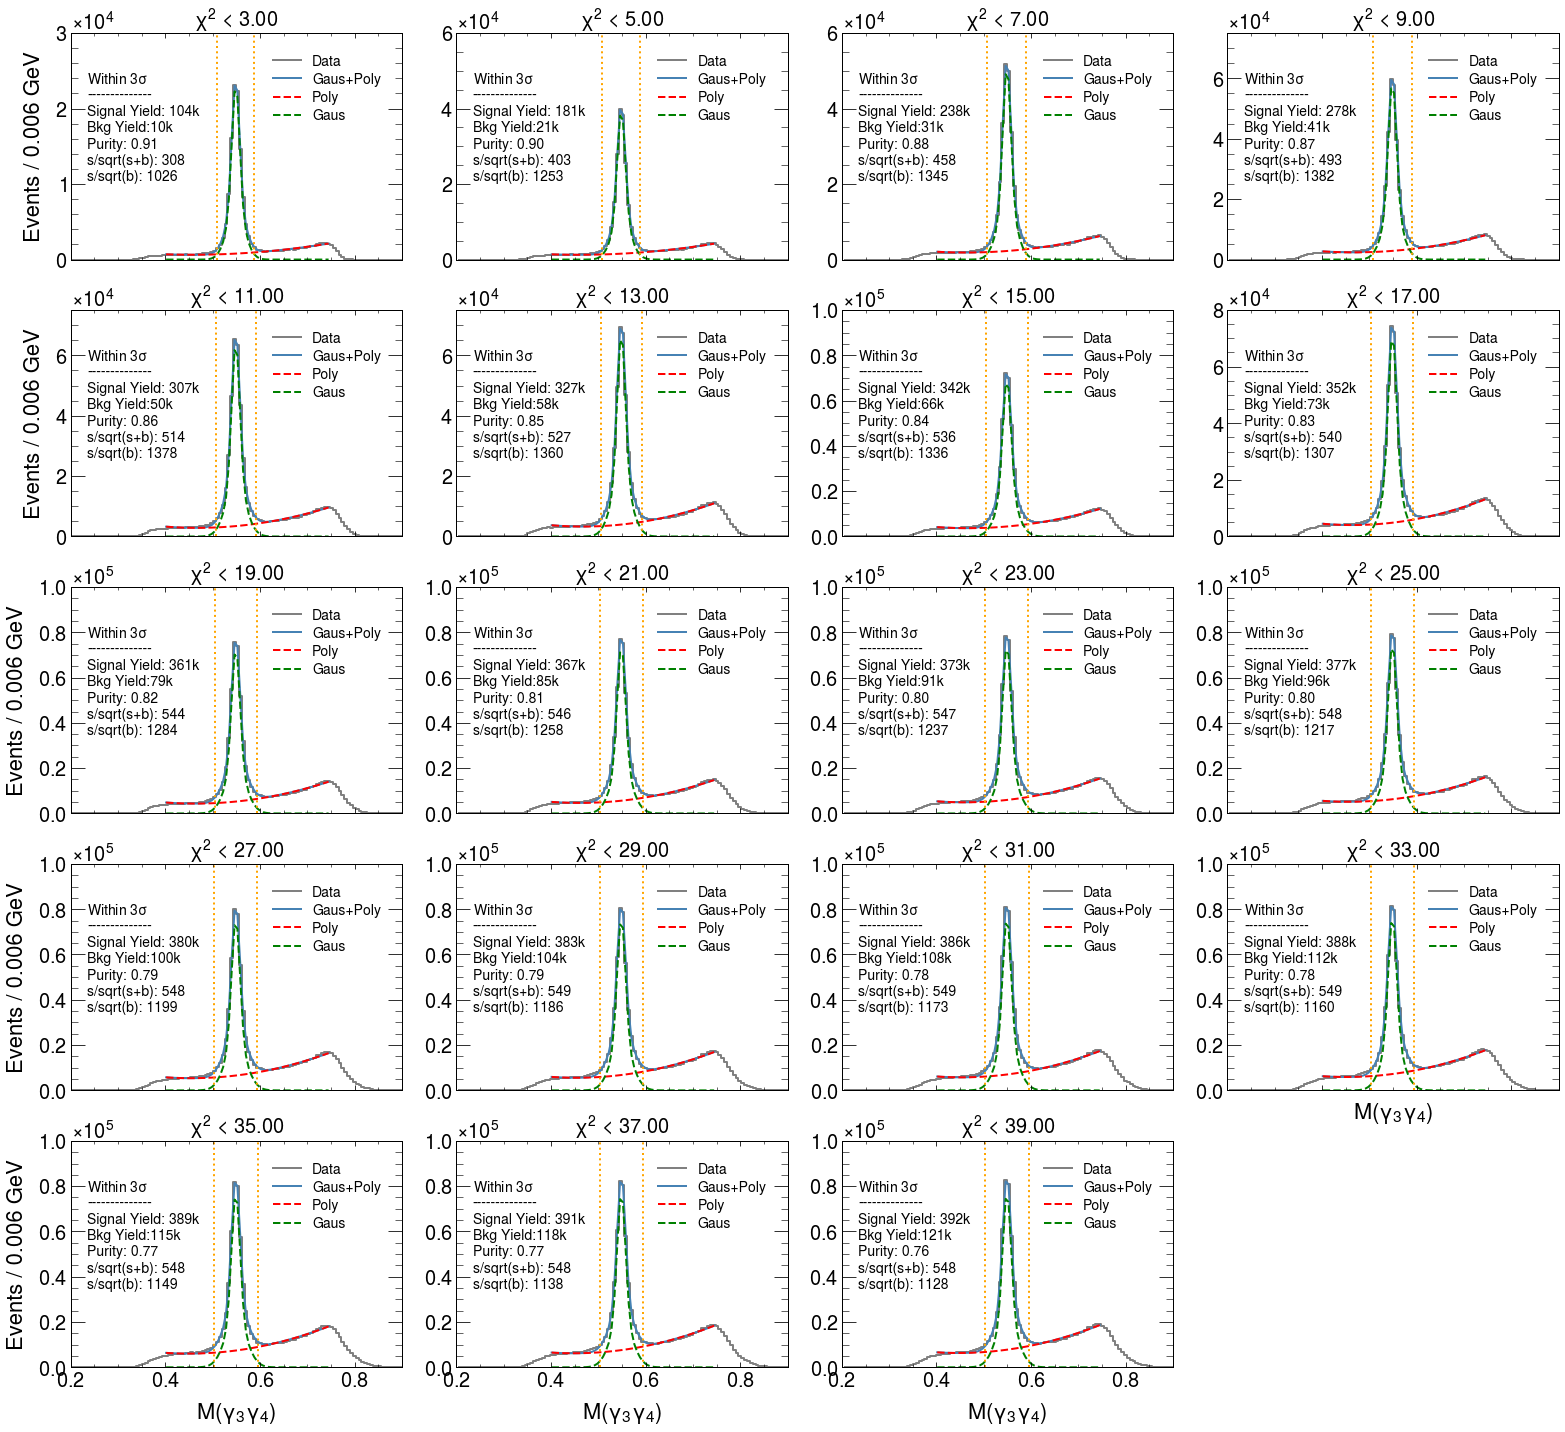

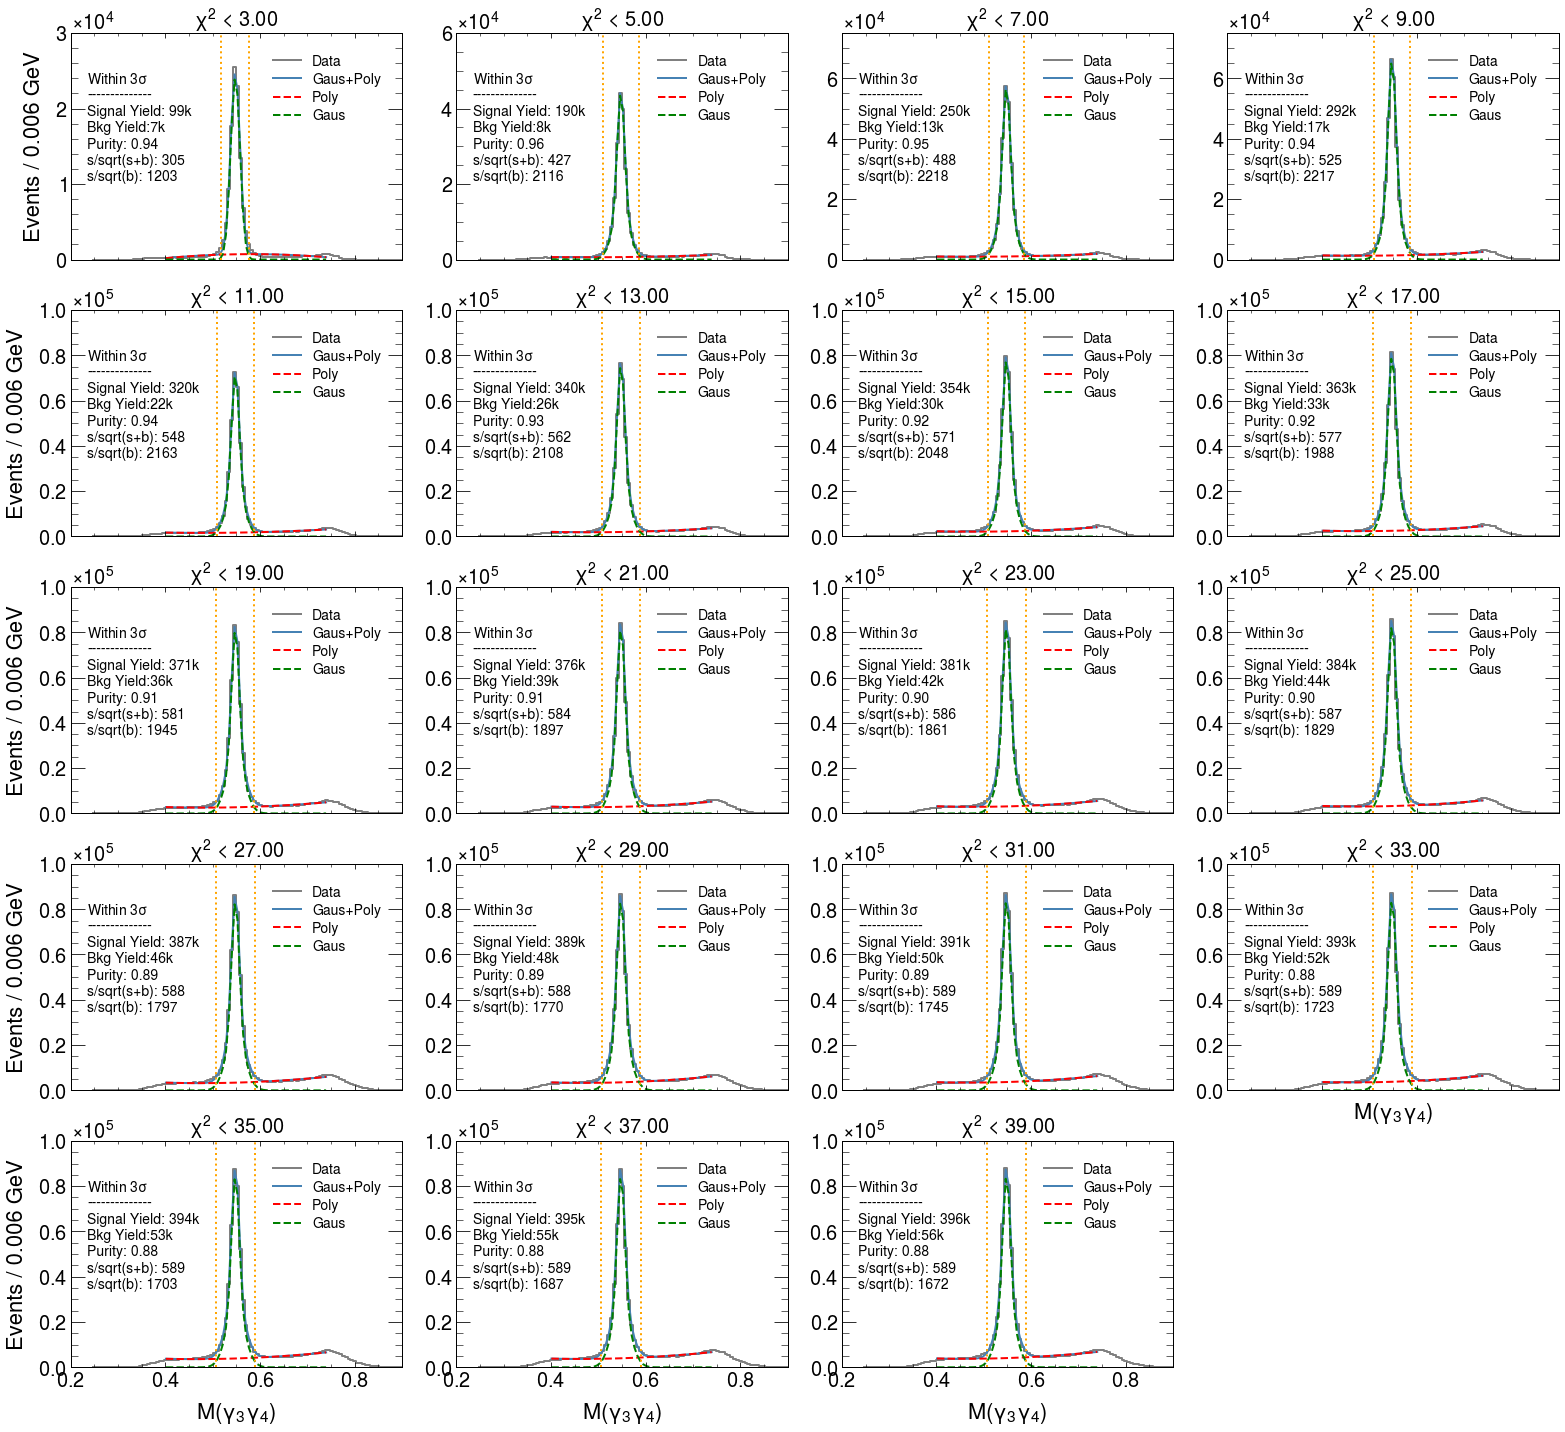

In [34]:
chiSqThresholds=np.arange(3,looseChiSq,2)
significances0=makeYieldFits(0,chiSqThresholds)
significances1=makeYieldFits(1,chiSqThresholds)
significances2=makeYieldFits(2,chiSqThresholds)

'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'STIX-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'STIX-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'STIX-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


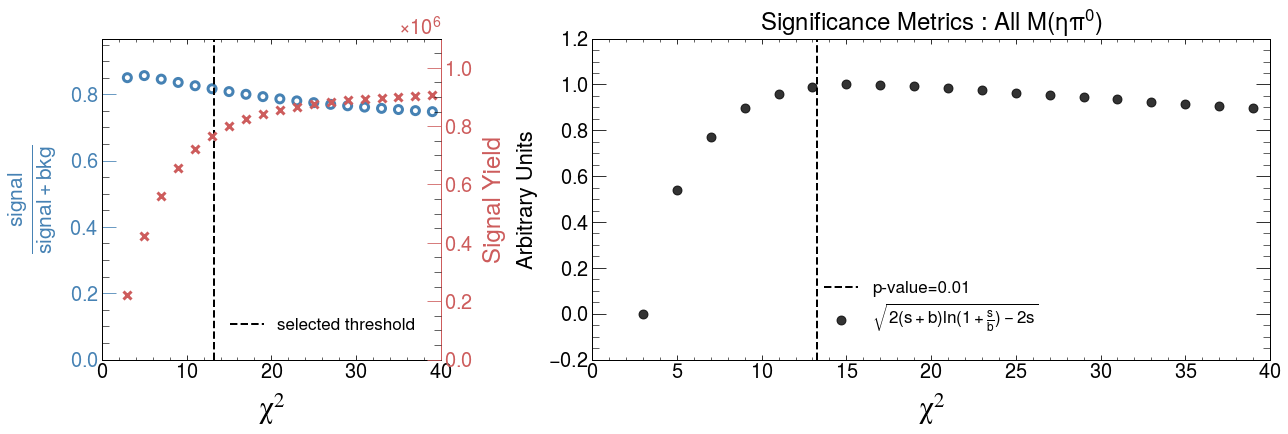

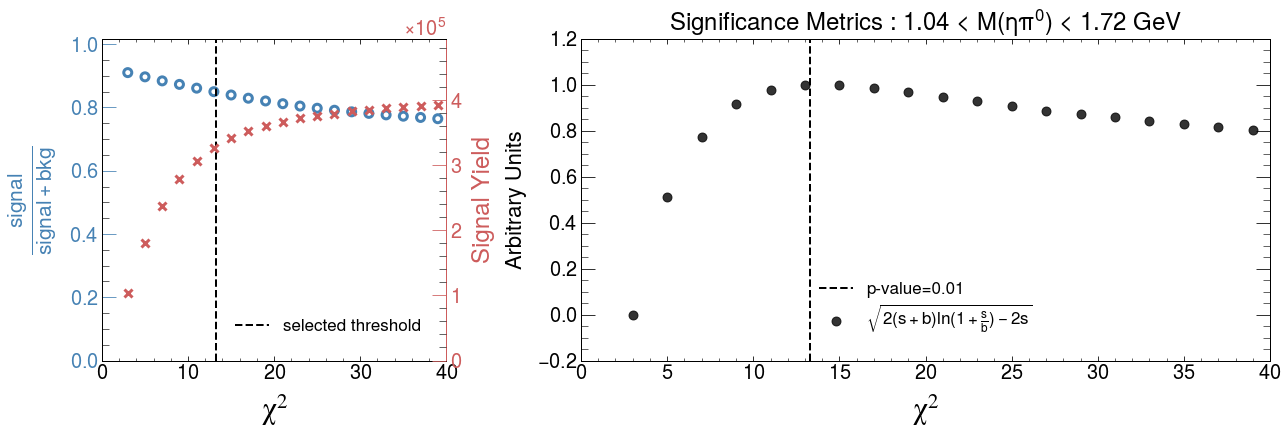

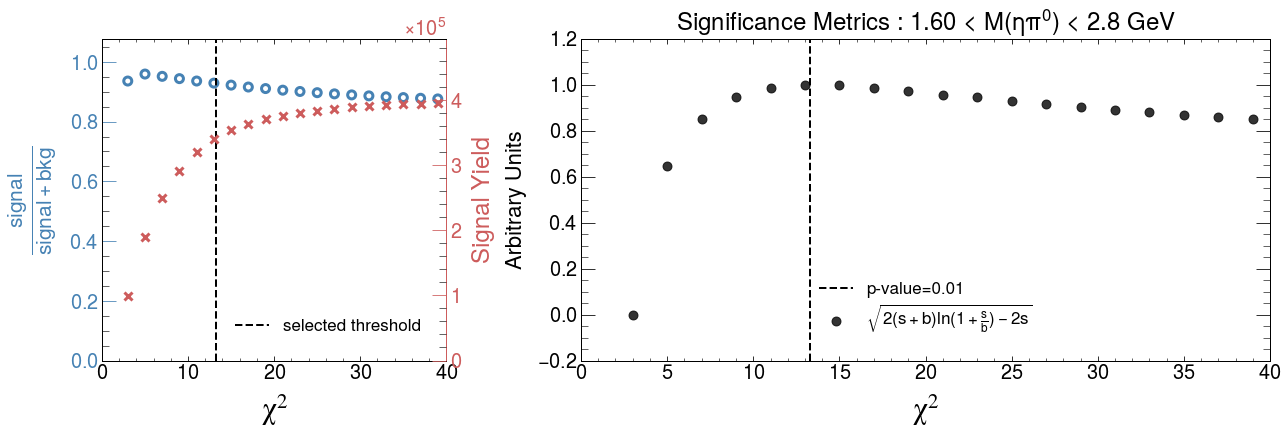

In [35]:
makeSignificancePlot(0,significances0,chiSqThresholds)#[::-1])
makeSignificancePlot(1,significances1,chiSqThresholds)#[::-1])
makeSignificancePlot(2,significances2,chiSqThresholds)#[::-1])

In [36]:
purityAtChi13_a2Region=significances1[0][np.where(chiSqThresholds==13)[0][0]]
purityAtChi13_DRregion=significances2[0][np.where(chiSqThresholds==13)[0][0]]
print(f'Purity (with chiSq=13) in a2 region: {purityAtChi13_a2Region:0.2f}, and double regge region: {purityAtChi13_DRregion:0.2f}')

Purity (with chiSq=13) in a2 region: 0.85, and double regge region: 0.93


(0.0, 6000.0)

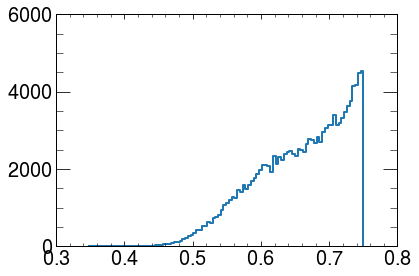

In [37]:
# tmp3=phase1_looseChi[(phase1_looseChi.Mpi0eta<0.95)&(phase1_looseChi.Mpi0eta>0.75)]
tmp3=phase1_looseChi[(phase1_looseChi.Mpi0eta<0.75)]
hep.histplot(np.histogram(tmp3.Mpi0eta,weights=tmp3.AccWeight,bins=100))
plt.ylim(0)

(0.0, 4000.0)

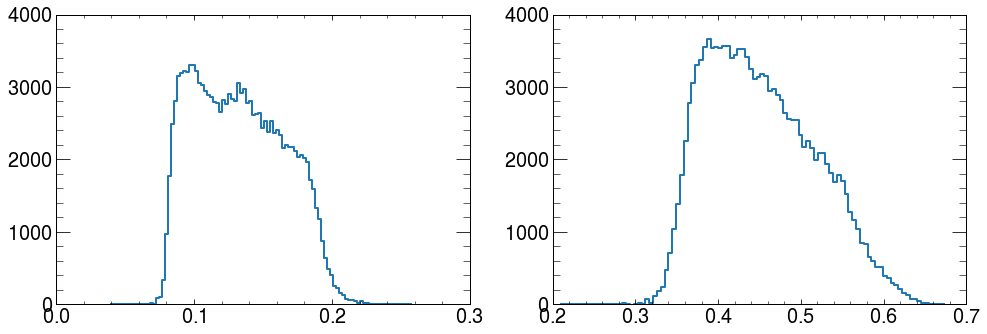

In [38]:
fig,axes=plt.subplots(1,2,figsize=(16,5))

hep.histplot(np.histogram(tmp3.Mpi0,weights=tmp3.AccWeight,bins=100),ax=axes[0])
axes[0].set_ylim(0)

hep.histplot(np.histogram(tmp3.Meta,weights=tmp3.AccWeight,bins=100),ax=axes[1])
axes[1].set_ylim(0)

# Draw systematic variations plots

In [39]:
tmp=phase1_looseChi[
    (phase1_looseChi.Mpi0eta>1.04)&(phase1_looseChi.Mpi0eta<1.72)
    &(phase1_looseChi.mandelstam_t<1.0)&(phase1_looseChi.mandelstam_t>0.1)
    &(phase1_looseChi.chiSq<13.277)
    &(phase1_looseChi.omegaCut)
    &(phase1_looseChi.pVH>0.5)
].reset_index(drop=True)

nominal yield: 338997
tighter yield: 323665
looser yield: 354737


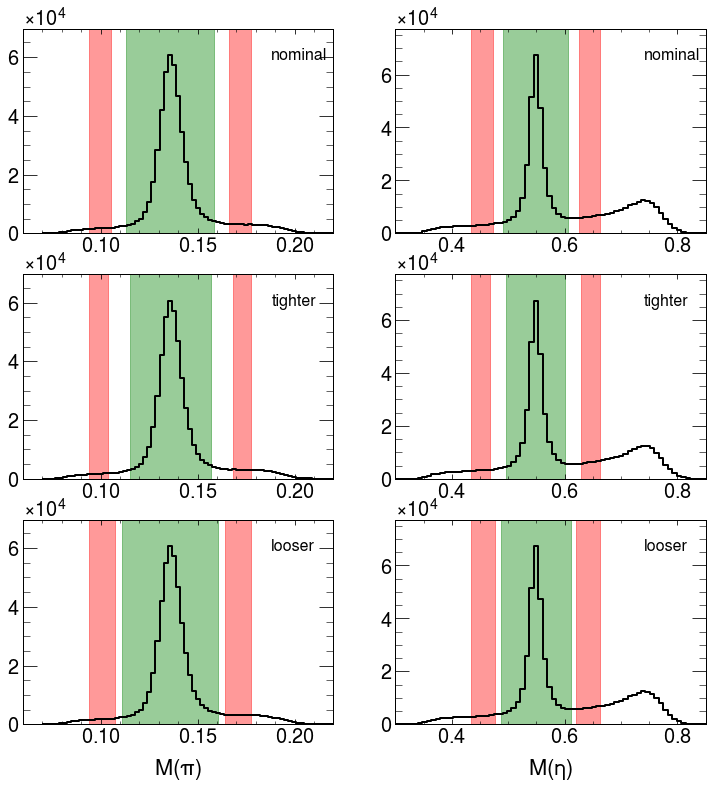

In [40]:
############## THIS STUDY IS FOR THE A2 CROSS SECTION

fig,axes=plt.subplots(3,2,figsize=(12,12))
axes=axes.flatten()

def drawSidebands(df,regions,axshift,text):
    pi0Mean=0.135881
    etaMean=0.548625
    pi0Std=0.0076
    etaStd=0.0191
#     regions2=[3.25, 0.5, 1.75, 3.25, 0.5, 2.25]
    for ax, var, pvar, min1, max1, mean, std, i in zip(axes[2*axshift:2*axshift+2],["Mpi0","Meta"],[r'$M(\pi)$',r'$M(\eta)$'],[0.06,0.3],[0.22,0.85],
                                                   [pi0Mean,etaMean],[pi0Std,etaStd],range(2)):
        out=np.histogram(df[var],weights=df['AccWeight'],bins=75)
        hep.histplot(out,ax=ax,c='black')
        ax.set_ylim(0,max(out[0])*1.15)
        ax.set_xlim(min1,max1)
        ax.axvspan(mean-regions[3*i]*std,mean+regions[0]*std,color='green',alpha=0.4)
        ax.axvspan(mean-sum(regions[3*i:3*i+3])*std,mean-sum(regions[3*i:3*i+2])*std,color='red',alpha=0.4)
        ax.axvspan(mean+sum(regions[3*i:3*i+2])*std,mean+sum(regions[3*i:3*i+3])*std,color='red',alpha=0.4)
        ax.text(0.80,0.85,text,transform=ax.transAxes,size=16)
        axes[4+i].set_xlabel(pvar)
        

def getYieldInRegion(df,regions,text):
    df2=df
    for var,mean,std,i in zip(['Mpi0','Meta'],[pi0Mean,etaMean],[pi0Std,etaStd],range(2)):
        df2=df2[
            ((df2[var]>mean-regions[3*i]*std)&(df2[var]<mean+regions[3*i]*std)) |
            ((df2[var]>mean-sum(regions[3*i:3*i+3]))&(df2[var]<mean-sum(regions[3*i:3*i+2])*std)) |
            ((df2[var]>mean+sum(regions[3*i:3*i+2])*std)&(df2[var]<mean+sum(regions[3*i:3*i+3])*std))
        ]
    print(f'{text} yield: {df2.AccWeight.sum():0.0f}')
    
regions=[3, 1, 1.5, 3, 1, 2]
drawSidebands(tmp,regions,0,'nominal')
getYieldInRegion(tmp,regions,'nominal')

regions=[2.75, 1.5, 1.25, 2.75, 1.5, 1.75]
drawSidebands(tmp,regions,1,'tighter')
getYieldInRegion(tmp,regions,'tighter')

regions=[3.25, 0.5, 1.75, 3.25, 0.5, 2.25]
drawSidebands(tmp,regions,2,'looser')
getYieldInRegion(tmp,regions,'looser')

plt.savefig(resultsFolder+"/")

# Double Regge

In [41]:
tmp=phase1_looseChi
tmp=tmp[tmp.chiSq<16]
tmp=tmp[(tmp.omegaCut)&(tmp.Mpi0eta<1) | (tmp.Mpi0eta>1)] # sneakily cut omegas out of threshold region only

'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


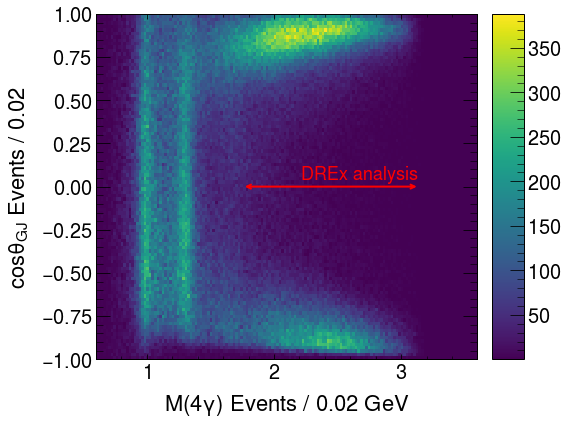

In [42]:
fig,axes=plt.subplots(1,1,figsize=(8,6))
axes=[axes]

hep.hist2dplot(np.histogram2d(tmp.Mpi0eta,tmp.cosTheta_eta_gj,weights=tmp.weightASBS,
                              bins=(getBinning(0.6,3.6,mstep),getBinning(-1,1,0.02))),ax=axes[0],linewidth=0,rasterized=True,vmin=0.0001)
axes[0].set_xlim(0.6,3.6)
axes[0].set_ylim(-1,1)
axes[0].set_xlabel(f"$M(4\gamma)$ Events / {mstep} GeV")
axes[0].set_ylabel(r"$cos\theta_{GJ}$ Events / 0.02")

# makePlot(tmp,"Mpi0eta",0.5,3,0.02,r"$M(4\gamma)$ GeV",axes[0],tmp.weightASBS,alpha=1,label="Phase 1 Data\n"+r"$E_{beam}\in[8.2,8.8] GeV$",c='black')
# axes[0].set_ylabel("Entries / %0.2f $GeV$" % (0.02))
# axes[0].legend(loc=1,bbox_to_anchor=(0.95,1))
# axes[0].set_ylim(0)

### annotate DREx region ###
for i,yloc in enumerate([0.5]):
    axes[i].annotate("",
                xy=(getFrac(1.6,mrange),yloc), xycoords='axes fraction',
                xytext=(getFrac(2.8,mrange), yloc), textcoords='axes fraction',
                arrowprops=dict(arrowstyle="<->",
                                connectionstyle="arc3", color='r', lw=2)
                )
    axes[i].text(getFrac(2.0,mrange), yloc+0.02, 'DREx analysis',fontsize = 18, transform=axes[i].transAxes,c='red')

plt.tight_layout()
plt.savefig(resultsFolder+"/dr_initialMassAngularPlot.pdf")

'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


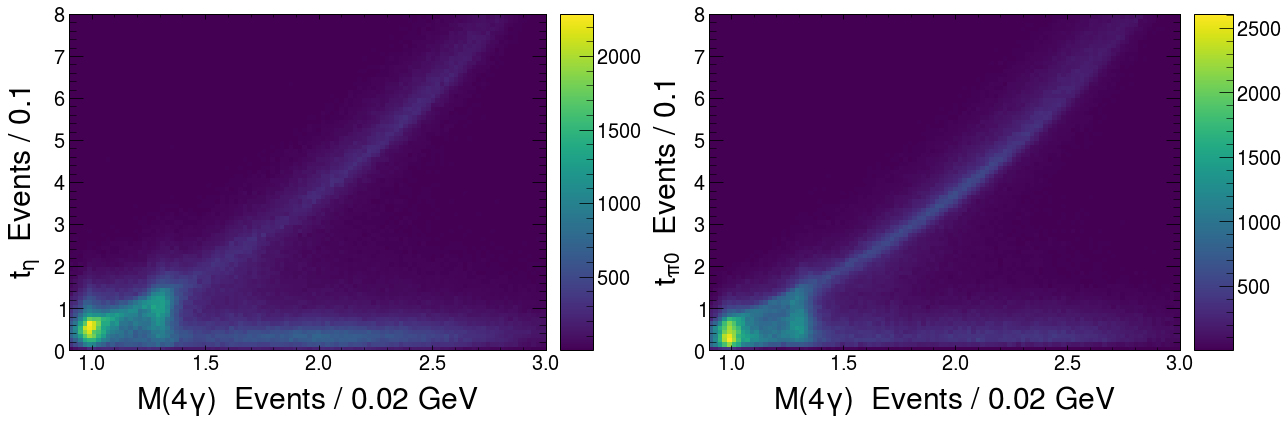

In [43]:
fig,axes=plt.subplots(1,2,figsize=(18,6))

hep.hist2dplot(np.histogram2d(tmp.Mpi0eta,tmp.mandelstam_teta,weights=tmp.weightASBS,bins=(getBinning(0.7,3.0,0.02),getBinning(0,8,0.1)))
               ,ax=axes[0],linewidth=0,rasterized=True,vmin=0.0001)
axes[0].set_xlabel("$M(4\gamma)$  Events / 0.02 GeV",size=30)
axes[0].set_ylabel(r"$t_{\eta}$  Events / 0.1",size=30)
axes[0].set_xlim(left=0.9)

plt.tight_layout()
# plt.savefig(resultsFolder+"/tetavsMpi0eta_allselect_accsub.pdf")

# fig,axes=plt.subplots(1,1,figsize=(10,6))
hep.hist2dplot(np.histogram2d(tmp.Mpi0eta,tmp.mandelstam_tpi0,weights=tmp.weightASBS,bins=(getBinning(0.7,3.0,0.02),getBinning(0,8,0.1)))
               ,ax=axes[1],linewidth=0,rasterized=True,vmin=0.0001)
axes[1].set_xlabel("$M(4\gamma)$  Events / 0.02 GeV",size=30)
axes[1].set_ylabel(r"$t_{\pi0}$  Events / 0.1",size=30)
axes[1].set_xlim(left=0.9)
plt.tight_layout()
plt.savefig(resultsFolder+"/tpi0AndtetavsMpi0eta_allselect_accsub.pdf")

In [44]:
phase1_df3=tmp[(tmp.Mpi0eta>1.6)&(tmp.Mpi0eta<2.8)] 

## Understanding combinatorial background

mean/weightedSigma = 0.548,0.012306
min/max range = 0.511,0.585


'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


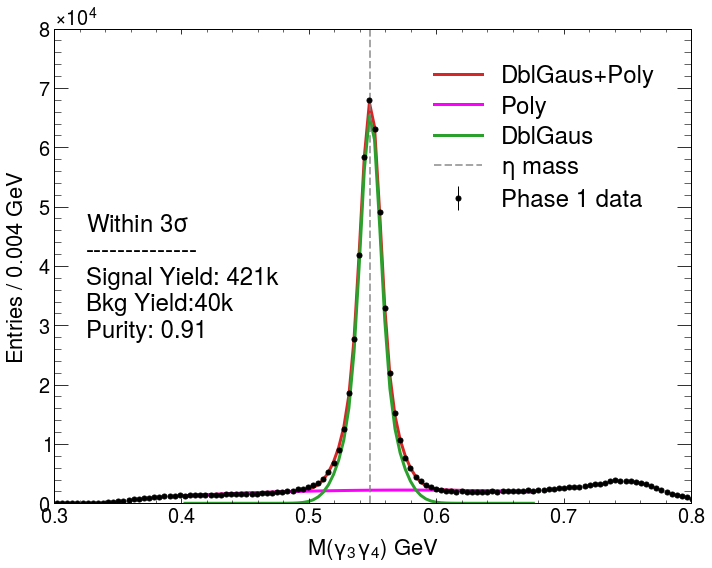

In [63]:
def poly(x, a, b, c):
    return a+b*x+c*x**2

def gaussian(x, A, mu, sig):
    return A*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

def doublegaussian(x, A, B, mu, sig, sig2):
    return gaussian(x,A,mu,sig)+gaussian(x,B,mu,sig2)
    #return A*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.))) + B*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig2, 2.)))

def fit(x, A, B, mu, sig, sig2, a, b, c):
    return doublegaussian(x,A,B,mu,sig,sig2)+poly(x,a,b,c)

def fitMass(df,var,binning,ax,minrange,maxrange,initparams):
    out=np.histogram(df[var],weights=df["AccWeight"],bins=binning)
    width=out[1][1]-out[1][0]
    centers=out[1][:-1]+(out[1][1]-out[1][0])/2

    #### Fits and plots the fit result curves
    yields_in_region=out[0][(centers>minrange)&(centers<maxrange)]
    centers_in_region=centers[(centers>minrange)&(centers<maxrange)]
    popt, pcov = curve_fit(fit,centers_in_region,yields_in_region,p0=initparams)
    ax.plot(centers_in_region,fit(centers_in_region, *popt),color='tab:red',label="DblGaus+Poly",linewidth=3)
    ax.plot(centers_in_region,poly(centers_in_region, *popt[5:]),color='magenta',linestyle='-',label="Poly",linewidth=3)
    ax.plot(centers_in_region,doublegaussian(centers_in_region, *popt[:5]),color='tab:green',linestyle='-',label="DblGaus",linewidth=3)

    #### Since we use a double gaussian we use a weighted sigma + draw the boundaries
    sig_yield1=quad(gaussian, popt[2]-3*abs(popt[3]), popt[2]+3*abs(popt[3]), args=(popt[0],popt[2],popt[3]))[0]
    sig_yield2=quad(gaussian, popt[2]-3*abs(popt[4]), popt[2]+3*abs(popt[4]), args=(popt[1],popt[2],popt[4]))[0]
    weightedSigma = sig_yield1/(sig_yield1+sig_yield2)*abs(popt[3])+sig_yield2/(sig_yield1+sig_yield2)*abs(popt[4])
    integral_minrange=popt[2]-3*abs(weightedSigma)
    integral_maxrange=popt[2]+3*abs(weightedSigma)
    print(f"mean/weightedSigma = {popt[2]:.3f},{weightedSigma:3f}")
    print(f"min/max range = {integral_minrange:.3f},{integral_maxrange:.3f}")
#     ax.axvline(integral_minrange,c='orange',linestyle='dotted',linewidth=4)
#     ax.axvline(integral_maxrange,c='orange',linestyle='dotted',linewidth=4)

    #### Calculate yields in bkg and signal curves
    bkg_yield=quad(poly, integral_minrange, integral_maxrange, args=tuple(popt[5:]))[0]
    sig_yield=quad(doublegaussian, integral_minrange, integral_maxrange, args=tuple(popt[:5]))[0]
    tot_yield=quad(fit, integral_minrange, integral_maxrange, args=tuple(popt))[0]
    bkg_yield/=width
    sig_yield/=width
    tot_yield/=width
    
    purity=sig_yield/(sig_yield+bkg_yield)
    significance_sb=sig_yield/np.sqrt(sig_yield+bkg_yield)
    significance_b=sig_yield/np.sqrt(bkg_yield)
    significance_sbb=2*(np.sqrt(sig_yield+bkg_yield)-np.sqrt(bkg_yield))
    significance_cl=np.sqrt(2*(sig_yield+bkg_yield)*np.log(1+sig_yield/bkg_yield)-2*sig_yield)
    ax.text(0.05,0.35,"Within 3$\sigma$\n--------------\nSignal Yield: %0.0fk\nBkg Yield:%0.0fk\nPurity: %0.2f" % (sig_yield/1000,bkg_yield/1000,purity),
            size=24,transform=ax.transAxes)

    return popt[2], weightedSigma
    
fig,ax=plt.subplots(1,1,figsize=(10,8))

#######################
#### These plots are supposed to match compareDoubleRegge jupyternotebook results. They dont quite match
####    BUT it can be seen that Mpi0p<2.2 removes much more of the bkg
#######################
# phase1_df3=phase1_df2[(phase1_df2.Mpi0eta>1.6)&(phase1_df2.Mpi0eta<2.8)]
# phase1_df3=phase1_df3[~phase1_df3.omegaCut]
# phase1_df3=phase1_df3[phase1_df3.mandelstam_t<5]
# phase1_df3=phase1_df3[(phase1_df3.Mpi0p<2.2)]
# phase1_df3=phase1_df3[(phase1_df3.Metap>2.0)]
# fig,axes=plt.subplots(1,5,figsize=(18,4))
# hep.histplot(np.histogram(phase1_df3.mandelstam_t,bins=100),ax=axes[0])
# axes[0].set_xlabel("mandelstam t")
# hep.histplot(np.histogram(phase1_df3.Ebeam,bins=50),ax=axes[1])
# axes[1].set_xlabel("Ebeam")
# hep.histplot(np.histogram(phase1_df3.Mpi0p,bins=100),ax=axes[2])
# axes[2].set_xlabel("Mpi0p")
# hep.histplot(np.histogram(phase1_df3.Metap,bins=100),ax=axes[3])
# axes[3].set_xlabel("Metap")
# hep.histplot(np.histogram(phase1_df3.Mpi0eta,bins=100),ax=axes[4])
# axes[4].set_xlabel("Mpi0eta")
# plt.tight_layout()
#######################
#######################

binning=getBinning(phase1_df3["Meta"].min(),phase1_df3["Meta"].max(),0.004)
hep.histplot(np.histogram(phase1_df3["Meta"],bins=binning,weights=phase1_df3["AccWeight"]),
             label="Phase 1 data",color='black',ax=ax,linewidth=4,histtype='errorbar',
             w2=np.histogram(phase1_df3["Meta"],bins=binning,weights=phase1_df3["AccWeight"]**2)[0]
            )
eta_peak, eta_std = fitMass(phase1_df3,"Meta",binning,ax,0.4,0.68,(500,500,0.55,0.05,0.05,1000,0,0))

# binning=getBinning(phase1_df3["Mpi0"].min(),phase1_df3["Mpi0"].max(),0.001)
# hep.histplot(np.histogram(phase1_df3["Mpi0"],bins=binning,weights=phase1_df3["AccWeight"]),label="Phase 1 data",color='black',ax=axes[0])
# pi0_peak, pi0_std = fitMass(phase1_df3,"Mpi0",binning,axes[0],0.08,0.19,(500,500,0.135,0.01,0.01,100,0,0))

# axes[0].axvline(pi0mass,c="gray",label=r"$\pi^0$ mass",linestyle='--',alpha=0.7)
ax.axvline(etamass,c="gray",label=r"$\eta$ mass",linestyle='--',alpha=0.7)
# axes[0].set_ylim(bottom=0)
ax.set_ylim(bottom=0)
ax.set_xlim(0.3,0.8)
# axes[0].legend()
ax.legend(prop={'size':24})
# axes[0].set_xlabel(r"$M(\gamma_1\gamma_2)$ GeV")
ax.set_xlabel(r"$M(\gamma_3\gamma_4)$ GeV")
# axes[0].set_ylabel("Entries / %0.3f $GeV$" % (0.001))
ax.set_ylabel("Entries / %0.3f $GeV$" % (0.004))
plt.tight_layout()
plt.savefig(resultsFolder+"/double_regge/double_regge_region_cuts_1dmass.pdf")

In [ ]:
fig,axes=plt.subplots(1,2,figsize=(14,5))

binning=getBinning(phase1_df3["Meta"].min(),phase1_df3["Meta"].max(),0.004)
hep.histplot(np.histogram(phase1_df3["Meta"],bins=binning,weights=phase1_df3["AccWeight"]),label="Phase 1 data",color='black',ax=axes[1])
axes[1].axvspan(eta_peak+5*eta_std,eta_peak+11*eta_std,color='red',alpha=0.2,label='sidebands')
axes[1].axvspan(eta_peak-11*eta_std,eta_peak-5*eta_std,color='red',alpha=0.2)
axes[1].axvspan(eta_peak-3*eta_std,eta_peak+3*eta_std,color='green',alpha=0.2,label='signal')

binning=getBinning(phase1_df3["Mpi0"].min(),phase1_df3["Mpi0"].max(),0.001)
hep.histplot(np.histogram(phase1_df3["Mpi0"],bins=binning,weights=phase1_df3["AccWeight"]),label="Phase 1 data",color='black',ax=axes[0])
axes[0].axvspan(pi0_peak+4*pi0_std,pi0_peak+7*pi0_std,color='red',alpha=0.2,label='sidebands')
axes[0].axvspan(pi0_peak-7*pi0_std,pi0_peak-4*pi0_std,color='red',alpha=0.2)
axes[0].axvspan(pi0_peak-3*pi0_std,pi0_peak+3*pi0_std,color='green',alpha=0.2,label='signal')

axes[0].axvline(pi0mass,c="gray",label=r"$\pi^0$ mass",linestyle='--',alpha=0.7)
axes[1].axvline(etamass,c="gray",label=r"$\eta$ mass",linestyle='--',alpha=0.7)
axes[0].set_ylim(bottom=0)
axes[1].set_ylim(bottom=0)
axes[0].legend()
axes[1].legend()
axes[0].set_xlabel(r"$M(\gamma_1\gamma_2)$ GeV")
axes[1].set_xlabel(r"$M(\gamma_3\gamma_4)$ GeV")
axes[0].set_ylabel("Entries / %0.3f $GeV$" % (0.001))
axes[1].set_ylabel("Entries / %0.3f $GeV$" % (0.004))
plt.tight_layout()
plt.savefig(resultsFolder+"/double_regge/double_regge_region_sidebands.pdf")

### Checking asymmetry of combinatorial background

Text(0.5, 0, '$\\phi_{lab}$')

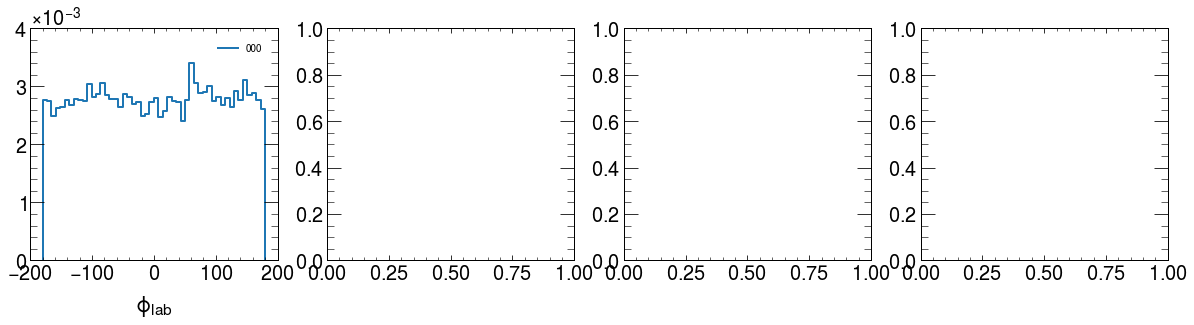

In [578]:
fig,axes=plt.subplots(1,4,figsize=(20,4))
#axes=axes.flatten()

for poltag,pol in zip(["000"],[0,45,90,135,-1]):
    tmp=phase1_df3[phase1_df3.BeamAngle==pol]
    tmp_sig=tmp[tmp.weightBS==1]
    tmp_sb=tmp[~tmp.weightBS.isin([1,0])]
    out=np.histogram(tmp_sb.phi_eta_lab,weights=-1*tmp_sb.weightBS,bins=50)
    hep.histplot(out,density=True,label=poltag,ax=axes[0])
axes[0].set_ylim(bottom=0)
axes[0].legend(prop={"size":10})
axes[0].set_xlabel(r"$\phi_{lab}$")

## DR kinematic variable overview plots

In [579]:
def makeHist(df,var):
    out=np.histogram(tmp[var],weights=tmp.AccWeight,bins=50)
    binwidth=out[1][1]-out[1][0]
    return out, binwidth

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


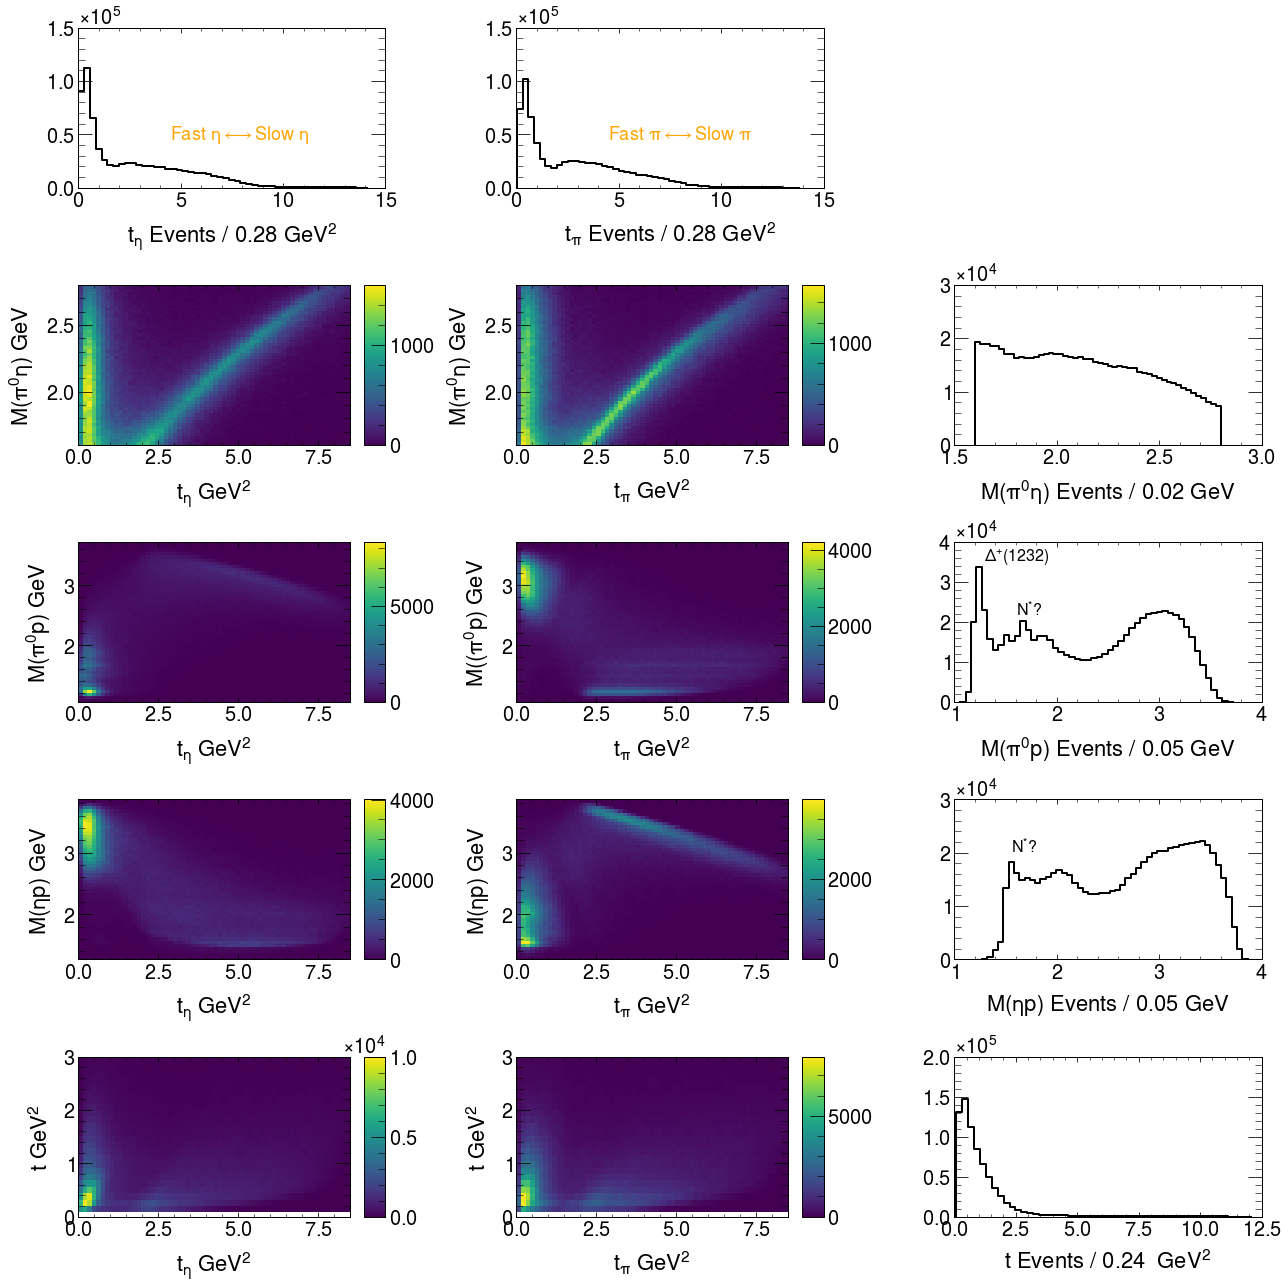

In [827]:
fig,axes=plt.subplots(5,3,figsize=(18,18))

## These selections are just so the plotting looks better
tmp=phase1_df3 #[(phase1_df3.mandelstam_teta<8.5)&(phase1_df3.mandelstam_tpi0<8.5)&(phase1_df3.mandelstam_t<3)]

# 1D t1 distributions
out, binwidth = makeHist(tmp,"mandelstam_teta")
hep.histplot(out,ax=axes[0,0],color='black')
axes[0,0].text(0.3,0.3,r"$Fast~\eta\longleftrightarrow Slow~\eta$",transform=axes[0,0].transAxes,color='orange',size=18)
axes[0,0].set_xlabel(r"$t_{\eta}$ Events / %0.2f $GeV^2$" % binwidth)
out, binwidth = makeHist(tmp,"mandelstam_tpi0")
hep.histplot(out,ax=axes[0,1],color='black')
axes[0,1].text(0.3,0.3,r"$Fast~\pi\longleftrightarrow Slow~\pi$",transform=axes[0,1].transAxes,color='orange',size=18)
axes[0,1].set_xlabel(r"$t_{\pi}$ Events / %0.2f $GeV^2$" % binwidth)

### Mpi0eta
hep.hist2dplot(np.histogram2d(tmp.mandelstam_teta,tmp.Mpi0eta,weights=tmp.AccWeight,bins=(100,50)),ax=axes[1,0],linewidth=0,rasterized=True)
axes[1,0].set_ylabel(r"$M(\pi^{0}\eta)$ GeV")
axes[1,0].set_xlabel(r"$t_{\eta}~GeV^2$")
axes[1,0].set_xlim(0,8.5)
#axes[1,0].images[-1].colorbar.remove()
# axes[1,0].text(0.1,0.8,r"$Fast~\eta$",transform=axes[1,0].transAxes,color='orange',size=18)
# axes[1,0].text(0.5,0.8,r"$Slow~\eta$",transform=axes[1,0].transAxes,color='orange',size=18)
hep.hist2dplot(np.histogram2d(tmp.mandelstam_tpi0,tmp.Mpi0eta,weights=tmp.AccWeight,bins=(100,50)),ax=axes[1,1],linewidth=0,rasterized=True)
axes[1,1].set_ylabel(r"$M(\pi^{0}\eta)$ GeV")
axes[1,1].set_xlabel(r"$t_{\pi}~GeV^2$")
axes[1,1].set_xlim(0,8.5)
# axes[1,1].text(0.1,0.8,r"$Fast~\pi$",transform=axes[1,1].transAxes,color='orange',size=18)
# axes[1,1].text(0.5,0.8,r"$Slow~\pi$",transform=axes[1,1].transAxes,color='orange',size=18)
out, binwidth = makeHist(tmp,"Mpi0eta")
hep.histplot(out,ax=axes[1,2],color='black')
axes[1,2].set_xlabel(r"$M(\pi^{0}\eta)$ Events / %0.2f GeV" % binwidth)

### Mpi0p
hep.hist2dplot(np.histogram2d(tmp.mandelstam_teta,tmp.Mpi0p,weights=tmp.AccWeight,bins=(100,50)),ax=axes[2,0],linewidth=0,rasterized=True)
axes[2,0].set_ylabel(r"$M(\pi^{0}p)$ GeV")
axes[2,0].set_xlabel(r"$t_{\eta}~GeV^2$")
axes[2,0].set_xlim(0,8.5)
hep.hist2dplot(np.histogram2d(tmp.mandelstam_tpi0,tmp.Mpi0p,weights=tmp.AccWeight,bins=(100,50)),ax=axes[2,1],linewidth=0,rasterized=True)
axes[2,1].set_ylabel(r"$M((\pi^{0}p)$ GeV")
axes[2,1].set_xlabel(r"$t_{\pi}~GeV^2$")
axes[2,1].set_xlim(0,8.5)
out, binwidth = makeHist(tmp,"Mpi0p")
hep.histplot(out,ax=axes[2,2],color='black')
axes[2,2].set_xlabel(r"$M(\pi^{0}p)$ Events / %0.2f GeV" % binwidth)
addText(1.232,out,1.05,1.05,r"$\Delta^{+}(1232)$",axes[2,2],16)
addText(1.6,out,1.0,1.3,r"$N^{*}?$",axes[2,2],16)


### Metap
hep.hist2dplot(np.histogram2d(tmp.mandelstam_teta,tmp.Metap,weights=tmp.AccWeight,bins=(100,50)),ax=axes[3,0],linewidth=0,rasterized=True)
axes[3,0].set_ylabel(r"$M(\eta p)$ GeV")
axes[3,0].set_xlabel(r"$t_{\eta}~GeV^2$")
axes[3,0].set_xlim(0,8.5)
hep.hist2dplot(np.histogram2d(tmp.mandelstam_tpi0,tmp.Metap,weights=tmp.AccWeight,bins=(100,50)),ax=axes[3,1],linewidth=0,rasterized=True)
axes[3,1].set_ylabel(r"$M(\eta p)$ GeV")
axes[3,1].set_xlabel(r"$t_{\pi}~GeV^2$")
axes[3,1].set_xlim(0,8.5)
out, binwidth = makeHist(tmp,"Metap")
hep.histplot(out,ax=axes[3,2],color='black')
axes[3,2].set_xlabel(r"$M(\eta p)$ Events / %0.2f GeV" % binwidth)
addText(1.55,out,1.0,1.1,r"$N^{*}?$",axes[3,2],16)

### t
hep.hist2dplot(np.histogram2d(tmp.mandelstam_teta,tmp.mandelstam_t,weights=tmp.AccWeight,bins=(100,100)),ax=axes[4,0],linewidth=0,rasterized=True)
axes[4,0].set_xlabel(r"$t_{\eta}~GeV^2$")
axes[4,0].set_ylabel(r"$t~GeV^2$")
axes[4,0].set_ylim(0,3)
axes[4,0].set_xlim(0,8.5)
hep.hist2dplot(np.histogram2d(tmp.mandelstam_tpi0,tmp.mandelstam_t,weights=tmp.AccWeight,bins=(100,100)),ax=axes[4,1],linewidth=0,rasterized=True)
axes[4,1].set_xlabel(r"$t_{\pi}~GeV^2$")
axes[4,1].set_ylabel(r"$t~GeV^2$")
axes[4,1].set_ylim(0,3)
axes[4,1].set_xlim(0,8.5)
out, binwidth = makeHist(tmp,"mandelstam_t")
hep.histplot(out,ax=axes[4,2],color='black')
axes[4,2].set_xlabel(r"$t$ Events / %0.2f $~GeV^2$" % binwidth)

axes[0,2].axis(False)

plt.tight_layout()
plt.savefig(resultsFolder+"/double_regge/double_regge_hist_overview.png")


Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


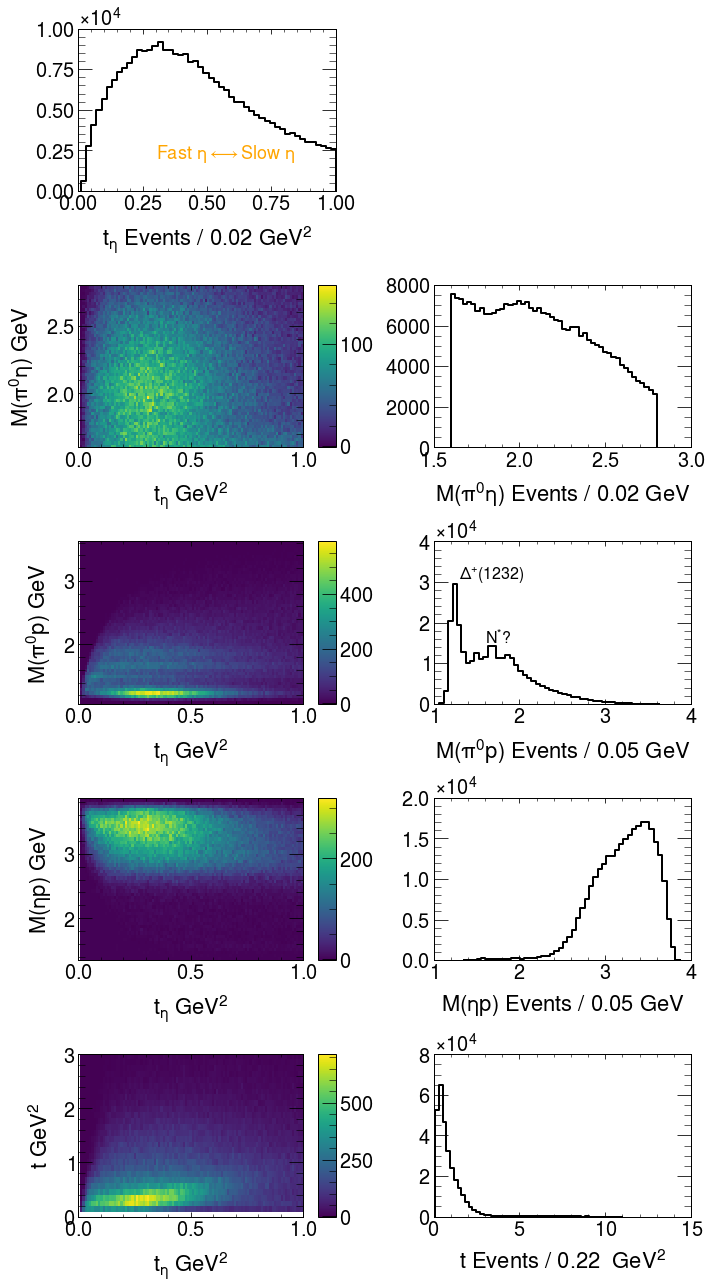

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


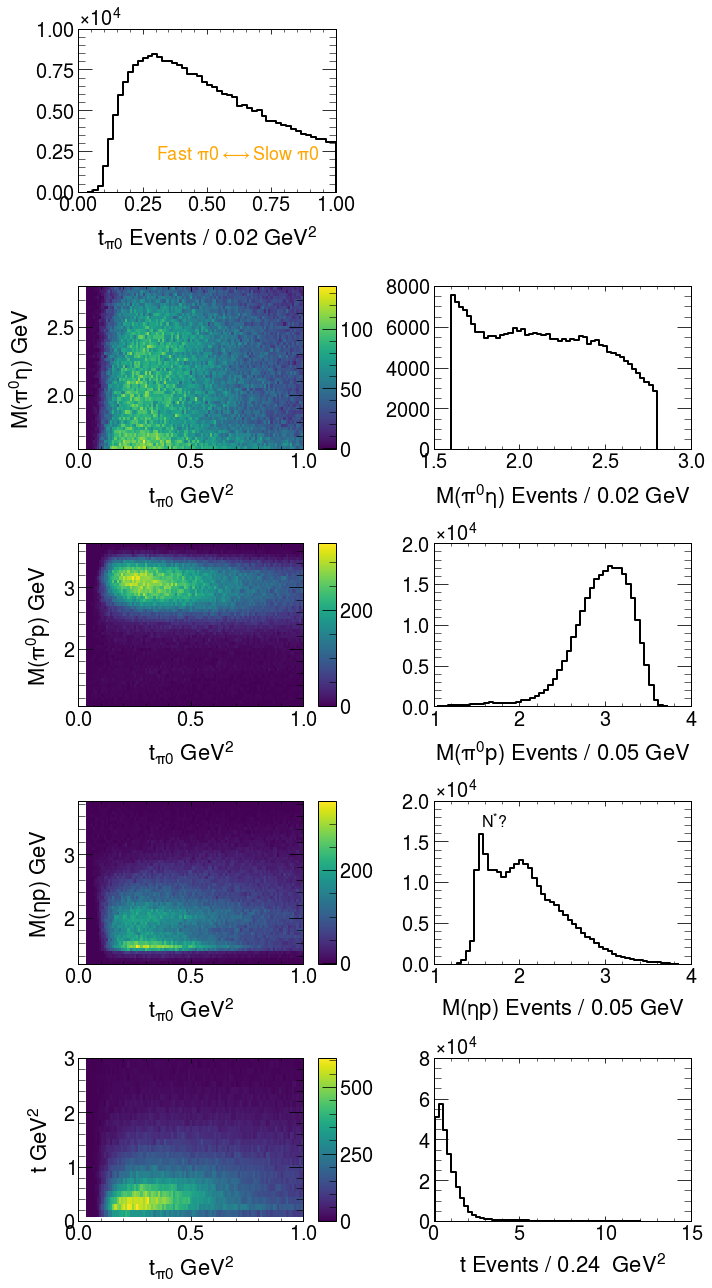

In [826]:
# fig,axes=plt.subplots(5,4,figsize=(20,18))

for idx, particle in enumerate(["eta","pi0"]):
    fig,axes=plt.subplots(5,2,figsize=(10,18))
    idx=0 # OVERWRITE IDX FOR NOW SINCE WE CURRENTLY DONT ACTUALLY WANT BOTH FAST ETA AND PI0 ON 
    tmp=phase1_df3 #[(phase1_df3.mandelstam_teta<8.5)&(phase1_df3.mandelstam_tpi0<8.5)&(phase1_df3.mandelstam_t<3)]
    tmp=tmp[tmp["mandelstam_t"+particle]<1]

    # 1D t1 distributions
    out, binwidth = makeHist(tmp,"mandelstam_t"+particle)
    hep.histplot(out,ax=axes[0,0+2*idx],color='black')
    axes[0,0+2*idx].text(0.3,0.2,r"$Fast~\{0}\longleftrightarrow Slow~\{0}$".format(particle),transform=axes[0,0+2*idx].transAxes,color='orange',size=18)
    axes[0,0+2*idx].set_xlabel(r"$t_{{\{0}}}$ Events / {1:.2f} $GeV^2$".format(particle,binwidth))

    ### Mpi0eta
    hep.hist2dplot(np.histogram2d(tmp["mandelstam_t"+particle],tmp.Mpi0eta,weights=tmp.AccWeight,bins=(100,50)),ax=axes[1,0+2*idx],linewidth=0,rasterized=True)
    axes[1,0+2*idx].set_ylabel(r"$M(\pi^{0}\eta)$ GeV")
    axes[1,0+2*idx].set_xlabel(r"$t_{{\{0}}}~GeV^2$".format(particle))
    axes[1,0+2*idx].set_xlim(0,1)
    out, binwidth = makeHist(tmp,"Mpi0eta")
    hep.histplot(out,ax=axes[1,1+2*idx],color='black')
    axes[1,1+2*idx].set_xlabel(r"$M(\pi^{0}\eta)$ Events / %0.2f GeV" % binwidth)

    ### Mpi0p
    hep.hist2dplot(np.histogram2d(tmp["mandelstam_t"+particle],tmp.Mpi0p,weights=tmp.AccWeight,bins=(100,50)),ax=axes[2,0+2*idx],linewidth=0,rasterized=True)
    axes[2,0+2*idx].set_ylabel(r"$M(\pi^{0}p)$ GeV")
    axes[2,0+2*idx].set_xlabel(r"$t_{{\{0}}}~GeV^2$".format(particle))
    axes[2,0+2*idx].set_xlim(0,1)
    out, binwidth = makeHist(tmp,"Mpi0p")
    hep.histplot(out,ax=axes[2,1+2*idx],color='black')
    axes[2,1+2*idx].set_xlabel(r"$M(\pi^{0}p)$ Events / %0.2f GeV" % binwidth)
    if particle=="eta":
        addText(1.232,out,1.05,1.05,r"$\Delta^{+}(1232)$",axes[2,1+2*idx],16)
        addText(1.6,out,1.0,1.3,r"$N^{*}?$",axes[2,1+2*idx],16)

    ### Metap
    hep.hist2dplot(np.histogram2d(tmp["mandelstam_t"+particle],tmp.Metap,weights=tmp.AccWeight,bins=(100,50)),ax=axes[3,0+2*idx],linewidth=0,rasterized=True)
    axes[3,0+2*idx].set_ylabel(r"$M(\eta p)$ GeV")
    axes[3,0+2*idx].set_xlabel(r"$t_{{\{0}}}~GeV^2$".format(particle))
    axes[3,0+2*idx].set_xlim(0,1)
    out, binwidth = makeHist(tmp,"Metap")
    hep.histplot(out,ax=axes[3,1+2*idx],color='black')
    axes[3,1+2*idx].set_xlabel(r"$M(\eta p)$ Events / %0.2f GeV" % binwidth)
    if particle=="pi0":
        addText(1.55,out,1.0,1.05,r"$N^{*}?$",axes[3,1+2*idx],16)

    ### t
    hep.hist2dplot(np.histogram2d(tmp["mandelstam_t"+particle],tmp.mandelstam_t,weights=tmp.AccWeight,bins=(100,100)),ax=axes[4,0+2*idx],linewidth=0,rasterized=True)
    axes[4,0+2*idx].set_xlabel(r"$t_{{\{0}}}~GeV^2$".format(particle))
    axes[4,0+2*idx].set_ylabel(r"$t~GeV^2$")
    axes[4,0+2*idx].set_ylim(0,3)
    axes[4,0+2*idx].set_xlim(0,1)
    out, binwidth = makeHist(tmp,"mandelstam_t")
    hep.histplot(out,ax=axes[4,1+2*idx],color='black')
    axes[4,1+2*idx].set_xlabel(r"$t$ Events / %0.2f $~GeV^2$" % binwidth)

    axes[0,1+2*idx].axis(False)

    plt.tight_layout()
    plt.savefig(resultsFolder+"/double_regge/double_regge_hist_overview_fast{0}.png".format(particle))


## Checking for asymmetries in phi_lab for the sidebands

In [659]:
# 0: std = sqrt(abs(Sum(w)))
# 1: std = sqrt(Sum(w*w))
selection=1

def square_list(x):
    newlist=[]
    for item in x:
        if selection==0:
            newlist.append(item)
        else:
            newlist.append(item*item)
    return newlist

def getWeightedErrors(df,var,nbins):
    tmp0=df
    # digitize has 1 as the first bin and 0 as the underflow. There is a bin at len(bins) that is for the overflow.
    #    bins argument for np.histogram would be the binedges and we need nbins+1 edges to define nbins number of bins
    #    default digitize uses bin[i-1] <= x < bin[i] as the conditional so simply using max() as the upper limit
    #    will have at least one value that is in the overflow bin. We will add a small value to force no overflow
    edges=np.linspace(tmp0[var].min(),tmp0[var].max()+0.0000000001,nbins+1)
    digits=np.digitize(tmp0[var],bins=edges)
    # digit min/max seem to be (1,nbins+1) 
    # so when we use getWeightedErrors and then 
    # print("DIGIT MIN/MAX %i/%i"%(digits.min(),digits.max()))

    tmp0['digits']=digits
    tmp0['tmpWeight']=-1*tmp0.weightBS*tmp0.AccWeight
    if selection==0:
        tmp0=tmp0.groupby("digits").tmpWeight.aggregate(square_list).apply(sum).apply(abs).apply(np.sqrt)
        tmp0=tmp0.reindex(list(range(1,nbins+1)),fill_value=0) # there can be empty bins so we will ignore them
        return edges,digits,tmp0.values
    else:
        tmp0=tmp0.groupby("digits").tmpWeight.aggregate(square_list).apply(sum).apply(np.sqrt)
        tmp0=tmp0.reindex(list(range(1,nbins+1)),fill_value=0) # there can be empty bins so we will ignore them
        return edges,digits,tmp0.values

SHAPE OF DF (585, 19)
SUM OF WEIGHTS 199.96875
Empty DataFrame
Columns: [Mpi0eta, weightASBS]
Index: []
0.0
[3.78383176 3.74765552 5.08933858 4.63185725 3.51281137 4.596619
 4.05407781 3.74061325 2.64667392 3.40094197 4.01267523 3.7264888
 4.56399804 3.39576943 4.5697716  5.0772355  3.41641259 2.67803566
 3.12624975 4.58609055 2.68459145 3.40610665 2.6648757  1.59099026
 3.40223387 3.02334666 3.40223387 3.48770161 4.59279327 3.14447059
 3.03495264 2.12959063 2.20262627 2.63168791 3.03495264 3.01752693
 3.69807805 1.54616461 3.04073901 2.17855313]


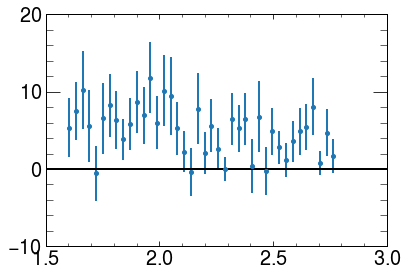

In [759]:
##########
## TEST COMPARE SELECTION 0 and 1
##########
tmp0=tmp.sample(10000)
tmp0=tmp0[~tmp0.weightBS.isin([1,0])]
print("SHAPE OF DF {}".format(tmp0.shape))
print("SUM OF WEIGHTS {}".format((-1*tmp0.weightBS*tmp0.AccWeight).sum()))

nbins=40
edges, digits, err=getWeightedErrors(tmp0,"Mpi0eta",nbins)

out=np.histogram(tmp0.Mpi0eta,weights=-1*tmp0.weightBS*tmp0.AccWeight,bins=edges)
plt.errorbar(out[1][:-1],out[0],yerr=err,fmt='.')

plt.axhline(0,c='black')

print(tmp0[digits==41][["Mpi0eta","weightASBS"]])
print(np.sqrt(tmp0[digits==41][["Mpi0eta","weightASBS"]].weightASBS.apply(lambda x:x**2).sum()))
print(err)

In [859]:
def overlayChiSqs(df,ax,xvar,yvar,includeHists):
    nbins=60
    xmin,xmax=ax.get_xlim()
    ymin,ymax=ax.get_ylim()
    xbins=3
    ybins=3
    xstep=(xmax-xmin)/xbins
    ystep=(ymax-ymin)/ybins
    
    for xbin in range(1,xbins):
        ax.axvline(xmin+xbin*xstep,c='orange')
    for ybin in range(1,ybins):
        ax.axhline(ymin+ybin*ystep,c='orange')
            
    if includeHists:
        fig,axes1=plt.subplots(3,3,figsize=(12,10))
        axes1=axes1.flatten()
    for ybin in range(ybins)[::-1][:1]: ## Reversing the order so we can match the outputs of includeHists bool
        tmp=df[(df[yvar]>(ymin+ybin*ystep))&(df[yvar]<(ymin+(ybin+1)*ystep))] 
#         print(ymin+ybin*ystep,ymin+(ybin+1)*ystep)
        tmp=tmp[tmp.BeamAngle==0]
        for xbin in range(xbins)[1:2]:
            tmp2=tmp[(tmp[xvar]>(xmin+xbin*xstep))&(tmp[xvar]<(xmin+(xbin+1)*xstep))]
#             print(xmin+xbin*xstep,xmin+(xbin+1)*xstep)
            tmp2=tmp2[~tmp2.weightBS.isin([1,0])]
            out=np.histogram(tmp2.phi_eta_lab,weights=-1*tmp2.weightBS*tmp2.AccWeight,bins=nbins)
            centers=out[1][:-1]+(out[1][1]-out[1][0])/2
        
            params=np.polyfit(centers, out[0], 0)    
            yfits=np.polyval(params,centers)
            edges, digits, std=getWeightedErrors(tmp2,"phi_eta_lab",nbins)
            #residuals=[np.power((yfits[i]-out[0][i])/np.sqrt(np.abs(out[0][i])),2) for i in range(len(yfits)) if np.sqrt(np.abs(out[0][i]))>0.00001]
            residuals=[np.power((yfits[i]-out[0][i])/std[i],2) for i in range(len(yfits)) if std[i]>0.00001]
            summed_resid=sum(residuals)
            nzerobins=sum(np.array(out[0])==0)
            dof=nbins-nzerobins-1 # DOF = k-c where k = # non-zero bins and c = number of parameters in fit https://www.itl.nist.gov/div898/handbook/eda/section3/eda35f.htm
            
#             print("====================================\n====================================")
#             print("row,col=%i,%i"%(ybin,xbin))
#             print("yfits: {}".format(yfits))
#             print("out[0]: {}".format(out[0]))
#             print("std: {}".format(std))
#             print("residuals: {}".format(residuals))
#             print("summed_resid: {}".format(summed_resid))
            
            ax.text(xmin+(xbin+0.25)*xstep,ymin+(ybin+0.5)*ystep, f"{summed_resid/dof:.2f}",size=20,c='orange')
            if includeHists:
                #hep.histplot(out,ax=axes1[xbin+(ybins-1-ybin)*3])
                axes1[xbin+(ybins-1-ybin)*3].errorbar(centers,out[0],yerr=std,fmt='.')
                axes1[xbin+(ybins-1-ybin)*3].axhline(params[0],c='orange',linestyle='--',linewidth=4)
                #axes1[xbin+(ybins-1-ybin)*3].set_ylim(bottom=0)
                axes1[xbin+(ybins-1-ybin)*3].set_xlim(-180,180)
                
                axes1[6].set_xlabel(r"$\phi_{\eta,lab}$")
                axes1[7].set_xlabel(r"$\phi_{\eta,lab}$")
                axes1[8].set_xlabel(r"$\phi_{\eta,lab}$")
                axes1[0].set_ylabel("Events / 6 degrees")
                axes1[3].set_ylabel("Events / 6 degrees")
                axes1[6].set_ylabel("Events / 6 degrees")
                
    if includeHists:
        plt.tight_layout()
        plt.savefig(resultsFolder+"/double_regge/double_regge_hist_sbFlatness_sampleFits.png")
    return tmp2, edges, digits, std


In [860]:
##### IF YOU WANT TO QUICKLY TEST OVERLAYCHISQ CODE ON A SAMPLE DATASET DO IT HERE
####################################################################################
# fig,axes=plt.subplots(1,1,figsize=(12,10))
# hep.hist2dplot(np.histogram2d(tmp.mandelstam_teta,tmp.Mpi0eta,weights=tmp.AccWeight,bins=(50,50)),ax=axes,linewidth=0,rasterized=True)
# axes.set_ylabel(r"$M(\pi^{0}\eta)$ GeV")
            
# tmp=phase1_df3[(phase1_df3.mandelstam_teta<8.5)&(phase1_df3.mandelstam_tpi0<8.5)&(phase1_df3.mandelstam_t<3)]
# overlayChiSqs(tmp,axes,"mandelstam_teta","Mpi0eta",False)

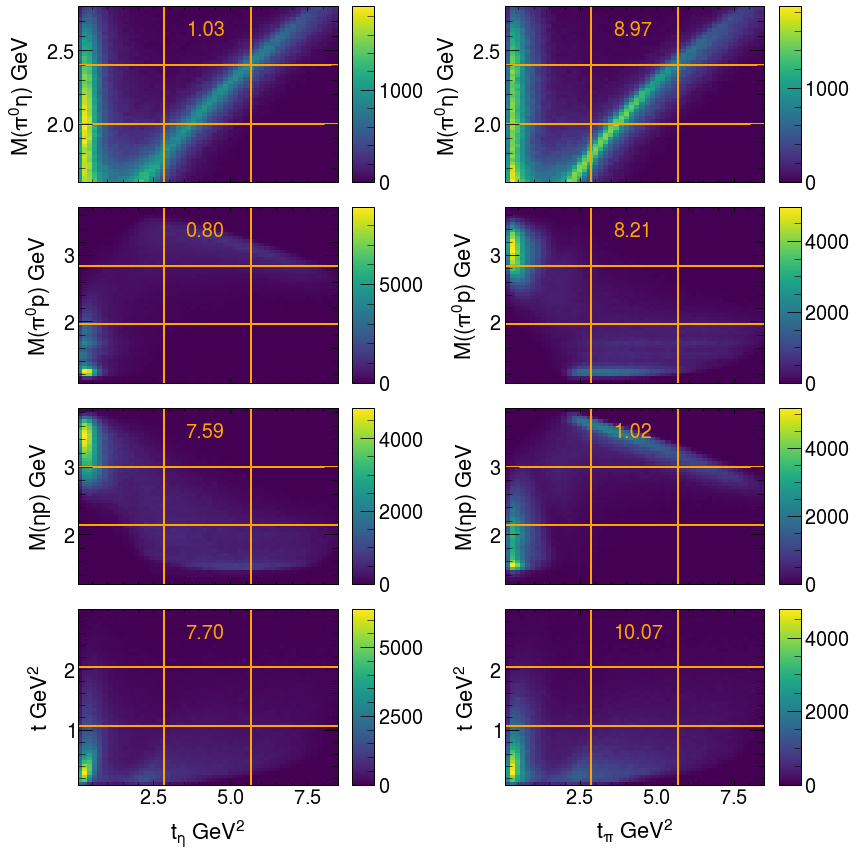

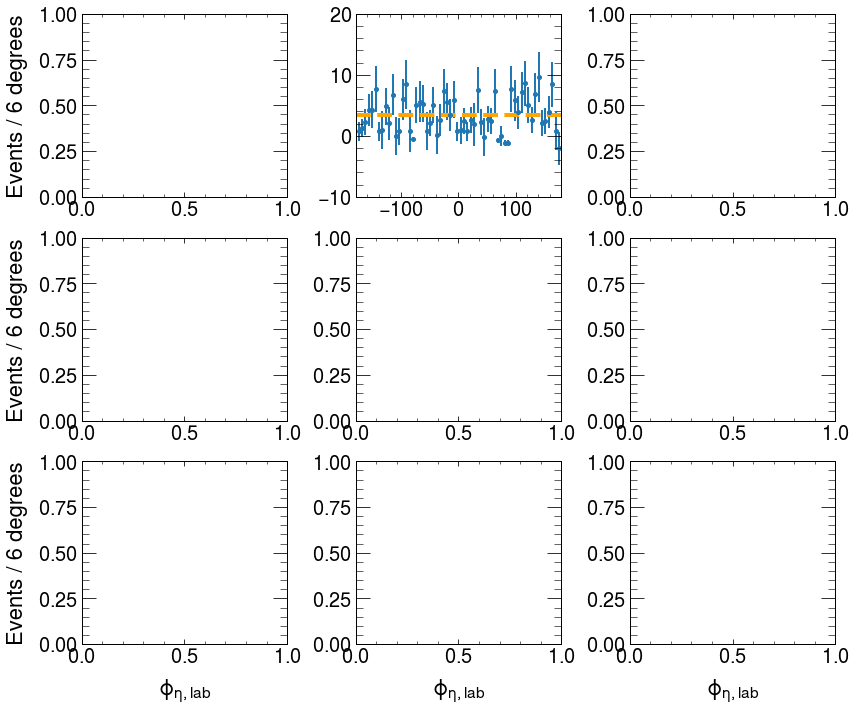

In [861]:
fig,axes=plt.subplots(4,2,figsize=(12,12),sharex=True)

## These selections are just so the plotting looks better
tmp=phase1_df3[(phase1_df3.mandelstam_teta<8.5)&(phase1_df3.mandelstam_tpi0<8.5)&(phase1_df3.mandelstam_t<3)]

### Mpi0eta
hep.hist2dplot(np.histogram2d(tmp.mandelstam_teta,tmp.Mpi0eta,weights=tmp.AccWeight,bins=(50,50)),ax=axes[0,0],linewidth=0,rasterized=True)
axes[0,0].set_ylabel(r"$M(\pi^{0}\eta)$ GeV")
overlayChiSqs(tmp,axes[0,0],"mandelstam_teta","Mpi0eta",False)
hep.hist2dplot(np.histogram2d(tmp.mandelstam_tpi0,tmp.Mpi0eta,weights=tmp.AccWeight,bins=(50,50)),ax=axes[0,1],linewidth=0,rasterized=True)
axes[0,1].set_ylabel(r"$M(\pi^{0}\eta)$ GeV")
tmp2, edges, digits, std = overlayChiSqs(tmp,axes[0,1],"mandelstam_tpi0","Mpi0eta",True)

# ### Mpi0p
hep.hist2dplot(np.histogram2d(tmp.mandelstam_teta,tmp.Mpi0p,weights=tmp.AccWeight,bins=(50,50)),ax=axes[1,0],linewidth=0,rasterized=True)
axes[1,0].set_ylabel(r"$M(\pi^{0}p)$ GeV")
overlayChiSqs(tmp,axes[1,0],"mandelstam_teta","Mpi0p",False)
hep.hist2dplot(np.histogram2d(tmp.mandelstam_tpi0,tmp.Mpi0p,weights=tmp.AccWeight,bins=(50,50)),ax=axes[1,1],linewidth=0,rasterized=True)
axes[1,1].set_ylabel(r"$M((\pi^{0}p)$ GeV")
overlayChiSqs(tmp,axes[1,1],"mandelstam_tpi0","Mpi0p",False)

# ### Metap
hep.hist2dplot(np.histogram2d(tmp.mandelstam_teta,tmp.Metap,weights=tmp.AccWeight,bins=(50,50)),ax=axes[2,0],linewidth=0,rasterized=True)
axes[2,0].set_ylabel(r"$M(\eta p)$ GeV")
overlayChiSqs(tmp,axes[2,0],"mandelstam_teta","Metap",False)
hep.hist2dplot(np.histogram2d(tmp.mandelstam_tpi0,tmp.Metap,weights=tmp.AccWeight,bins=(50,50)),ax=axes[2,1],linewidth=0,rasterized=True)
axes[2,1].set_ylabel(r"$M(\eta p)$ GeV")
overlayChiSqs(tmp,axes[2,1],"mandelstam_tpi0","Metap",False)

# ### t
hep.hist2dplot(np.histogram2d(tmp.mandelstam_teta,tmp.mandelstam_t,weights=tmp.AccWeight,bins=(50,50)),ax=axes[3,0],linewidth=0,rasterized=True)
axes[3,0].set_xlabel(r"$t_{\eta}~GeV^2$")
axes[3,0].set_ylabel(r"$t~GeV^2$")
overlayChiSqs(tmp,axes[3,0],"mandelstam_teta","mandelstam_t",False)
hep.hist2dplot(np.histogram2d(tmp.mandelstam_tpi0,tmp.mandelstam_t,weights=tmp.AccWeight,bins=(50,50)),ax=axes[3,1],linewidth=0,rasterized=True)
axes[3,1].set_xlabel(r"$t_{\pi}~GeV^2$")
axes[3,1].set_ylabel(r"$t~GeV^2$")
overlayChiSqs(tmp,axes[3,1],"mandelstam_tpi0","mandelstam_t",False)

plt.tight_layout()
plt.savefig(resultsFolder+"/double_regge/double_regge_hist_sbFlatness.png")
